# LLM Powered Sentiment Analyzer for Financial News

## Objective
Build a Python based sentiment analysis tool using a LLM API that analyses financial news articles, research
reports, or earnings call transcripts to generate sentiment scores related to equity markets The tool should
extract a sentiment score ( neutral, or negative) that quantifies a specific theme in a similar way to an
economist reading the article The advantage of this tool is that it will save many “economist hours” as the LLM
can quickly and reproducibly extract the same information from many documents Here the theme we will focus
on is the perception of the economy’s health i e .., “recession fears” in the US A positive score will mean that the fear of recession is present while a negative score will mean that we are recession safe

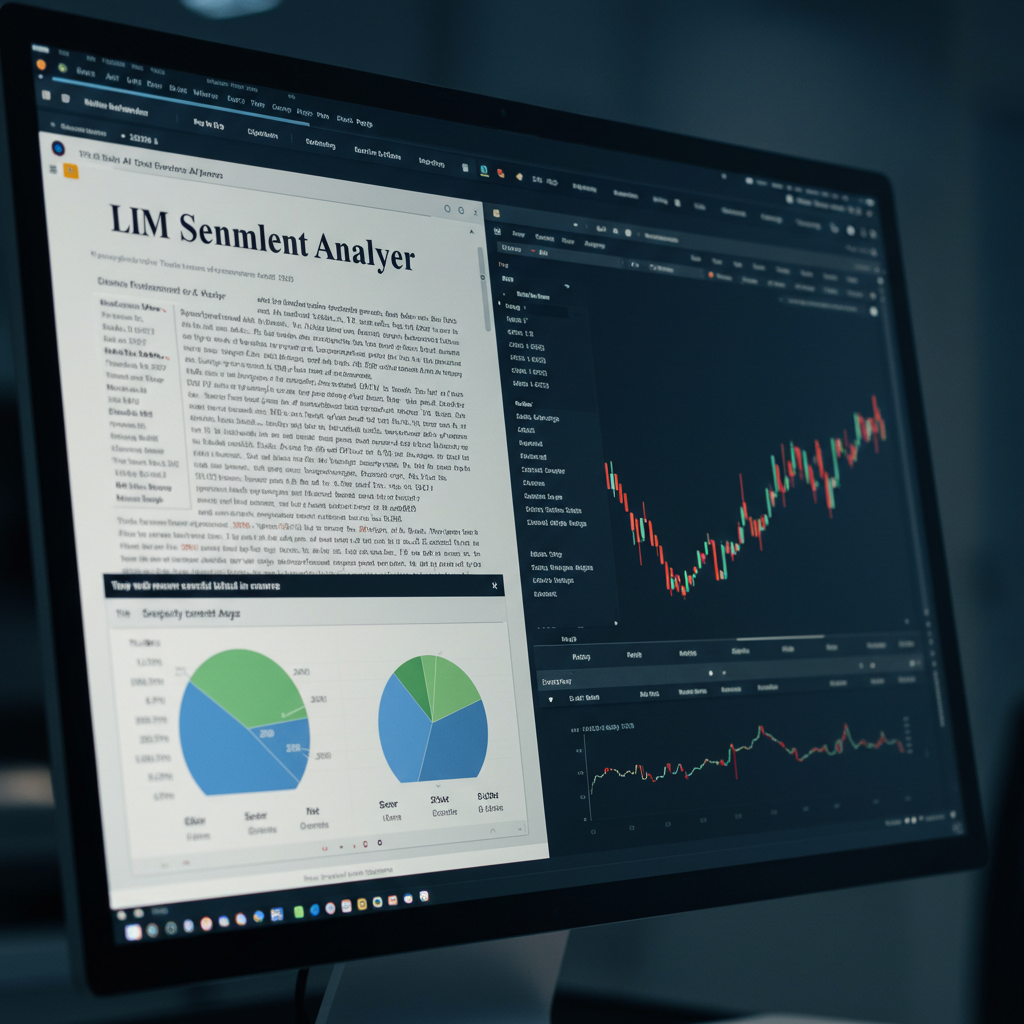

## **Importing Necessary Libraries**

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.set_option('display.max_colwidth', None)

from collections import Counter
import re

import requests
from newsapi import NewsApiClient
import yfinance as yf

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import torch
import evaluate
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset,Dataset
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from tqdm import tqdm 
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanusreedas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Variable Initialization:

- Change the API_KEY value to your own API key before running this notebook.

In [2]:
API_KEY = 'a1900cb224cd497b9a8e4f48e815dac7'

recession_data_path = '../data/us_recession_news.csv'
sector_specific_data = '../data/us_sector_news.csv'
fine_tuned_model_path = './fine_tuned_models'

results_dir = 'results'
logs_dir = 'logs'
model_ver= 'model_v1.0'

# Step1:
  ### Live News Data Preparation, EDA and Cleaning:

## **Preparing the dataset**

💹 Fetching all the available news on recession fear in USA Economy.

In [3]:
news_url = f"https://newsapi.org/v2/everything?q=recession+fears+US+economy&apiKey={API_KEY}"

We will fetch the data once to reduce server hits, which will speed up the model. This approach ensures data consistency, so the model will always generate the same results, even if run later.

In [4]:
def fetch_and_store_data():
    if os.path.exists(recession_data_path):
        print("Data loaded from existing file.")
        return pd.read_csv(recession_data_path)
    else:
        response = requests.get(news_url)
        news = response.json()
        keys_to_fetch = ["publishedAt", "description", "content"]
        filtered_news = [{key: d[key] for key in keys_to_fetch if key in d} for d in news['articles']]
        data = pd.DataFrame(filtered_news)
        data.to_csv(recession_data_path, index=False)
        print("Data fetched and saved.")
        return data

#### Create a DataFrame with the relevant information:

In [5]:
data = fetch_and_store_data()
df = data.copy()

Data loaded from existing file.


## **Data Overview**

In [6]:
df.sample(5)

publishedAt  \
25  2025-02-09T07:06:07Z   
60  2025-01-29T16:30:01Z   
12  2025-02-05T14:21:50Z   
65  2025-01-25T17:11:49Z   
10  2025-01-31T17:02:21Z   

                                                                                                                                                                                                                                                                description  \
25                                                                                                          Some 14 million Ecuadorans will go to the polls Sunday to decide who will lead their violence-wracked Andean nation through its worst crisis in half a century.   
60                                                                                         The US has been experiencing a long "bull" stock market, that is rapid growth in stock prices, although this week tech stocks tumbled over the future prospects for US-built AI.   
12  “Nearly all men can stand adversity, but if you want to test a man’s character, give him power.” \n—Abraham Lincoln (1809-1865), 16th President of the United States, 1861-1865.\n“I am driven with a mission from God. God would tell …\nThe post The US Government o…   
65     At the beginning of each year, as is our tradition, we collaborate with Enterprise Technology Research to dig through the latest data and craft 10 predictions for the coming year. This year’s batch follows some annual favorites and new territory. In this Brea…   
10                                                                                                                                                 Homebuilder inventory is at its highest level in years, a trend real estate experts say could signal a coming recession.   

                                                                                                                                                                                                                        content  
25     Some 14 million Ecuadorans will go to the polls Sunday to decide who will lead their violence-wracked Andean nation through its worst crisis in half a century.\r\nSixteen candidates are vying to become… [+3769 chars]  
60     The US has been experiencing a long "bull" stock market, that is rapid growth in stock prices, although this week tech stocks tumbled over the future prospects for US-built AI.\r\nBut could the market … [+6168 chars]  
12  “Nearly all men can stand adversity, but if you want to test a man’s character, give him power.” \r\nAbraham Lincoln (1809-1865), 16th President of the United States, 1861-1865.\r\n“I am driven with a mi… [+15636 chars]  
65    At the beginning of each year, as is our tradition, we collaborate with Enterprise Technology Research to dig through the latest data and craft 10 predictions for the coming year.\r\nThis years batch f… [+34558 chars]  
10       The U.S. housing market is flashing warning signs that have real estate experts concerned. A surge in unsold new homes is reminiscent of past economic downturns, raising fears of a potential recessio… [+5589 chars]

### **Observation:**
1. Our data follows the UTC YYYY-MM-DD HH:MM:SS format.
2. The data in the “description” and “content” columns are not exactly the same; both may be useful. We will analyze the sentiment for a particular day using both columns and determine which one provides the better result.

In [7]:
df.describe()

publishedAt  \
count                     78   
unique                    76   
top     2025-02-13T12:30:00Z   
freq                       2   

                                                                                                                                                                                                             description  \
count                                                                                                                                                                                                                 78   
unique                                                                                                                                                                                                                74   
top     The odds of further interest rate cuts this year by the Federal Reserve dwindled last week as unemployment fell and more officials say they want to see how new policies from the White House affect the economy   
freq                                                                                                                                                                                                                   2   

                                                                                                                                                                                                                       content  
count                                                                                                                                                                                                                       78  
unique                                                                                                                                                                                                                      75  
top     Donald Trump is back in the White House, promising to use the United States's vast economic weight to hit back at China for its alleged unfair trade practices and role in the deadly American fentanyl… [+4598 chars]  
freq                                                                                                                                                                                                                         2

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   publishedAt  78 non-null     object
 1   description  78 non-null     object
 2   content      78 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


## **Checking The Shape Of The Data**

In [9]:
df.shape

(78, 3)

## **Checking For Missing Data**

In [10]:
df.isnull().sum().sum()

0

## **Checking For Duplicate Values**

In [11]:
df['publishedAt'].duplicated().sum()

2

In [12]:
df[df.duplicated(subset=["publishedAt"], keep=False)]

publishedAt  \
63  2025-01-16T16:00:00Z   
64  2025-01-16T16:00:00Z   
67  2025-02-13T12:30:00Z   
70  2025-02-13T12:30:00Z   

                                                                                                                                                    description  \
63                                                                              OPINION: Luxon's State of the Nation speech should outline urgent, bold reform.   
64                                                                              Opinion: Luxon's State of the Nation speech should outline urgent, bold reform.   
67  Wednesday's consumer price index report showed that inflation is punching back — and Trump could end up facing the same challenges that dragged down Biden.   
70  Wednesday's consumer price index report showed that inflation is punching back — and Trump could end up facing the same challenges that dragged down Biden.   

                                                                                                                                                                                                                         content  
63      Once Acts Treaty Principles Bill charade is over, Luxon will have the option of returning to Waitangi in 2026, positioning himself as a national unifier.\r\nBeehive strategists know the overwhelming ma… [+6085 chars]  
64      Once Acts Treaty Principles Bill charade is over, Luxon will have the option of returning to Waitangi in 2026, positioning himself as a national unifier.\r\nBeehive strategists know the overwhelming ma… [+6085 chars]  
67  JOSH BOAK and CHRISTOPHER RUGABER\r\nAssociated Press\r\nWASHINGTON As a candidate last year, Donald Trump suggested he could easily conquer inflation and ease voters' fears about the economy.\r\n"I will v… [+5492 chars]  
70  JOSH BOAK and CHRISTOPHER RUGABER\r\nAssociated Press\r\nWASHINGTON As a candidate last year, Donald Trump suggested he could easily conquer inflation and ease voters' fears about the economy.\r\n"I will v… [+6683 chars]

In [13]:
df = df.drop_duplicates(subset=["publishedAt"])

👇 2 rows should be deleted.

In [14]:
df.shape

(76, 3)

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual features.
* Plot of a word cloud for frequently used words in the news, covering both descriptions and content.

### news published date distribution:

In [15]:
df["publishedAt"] = pd.to_datetime(df["publishedAt"])

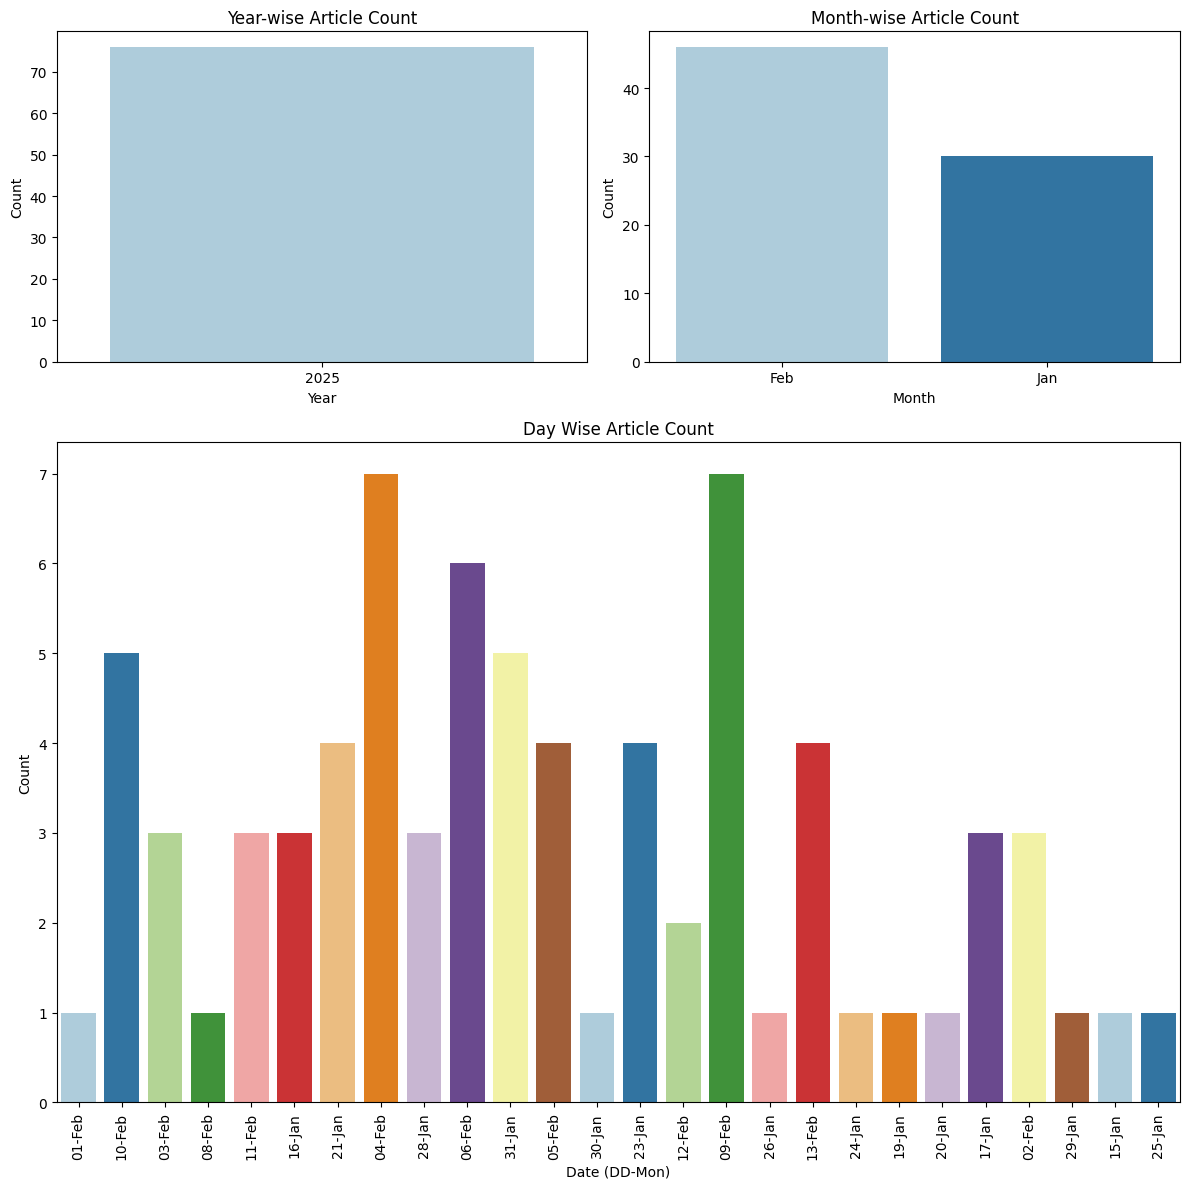

In [16]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(x=df['publishedAt'].dt.year, ax=ax1, palette="Paired")
ax1.set_title('Year-wise Article Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')

ax2 = fig.add_subplot(gs[0, 1])
sns.countplot(x=df['publishedAt'].dt.strftime('%b'), ax=ax2, palette="Paired")
ax2.set_title('Month-wise Article Count')
ax2.set_xlabel('Month')
ax2.set_ylabel('Count')

ax3 = fig.add_subplot(gs[1, :])
sns.countplot(x=df['publishedAt'].dt.strftime('%d-%b'), ax=ax3, palette="Paired")
ax3.set_title('Day Wise Article Count')
ax3.set_xlabel('Date (DD-Mon)')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Observation:

1. We only have data for January and February 2025.
2. A large number of news articles about recession fears were generated on February 4th and 9th. In fact, most of the January data is sparse, which could be due to the API’s free version or the lack of significant recession-related news in the USA during that time.

### ✅ We will use a Word Cloud to display words that appear more frequently in a larger font, while less frequent words will be shown in a smaller font.

### word cloud for description:

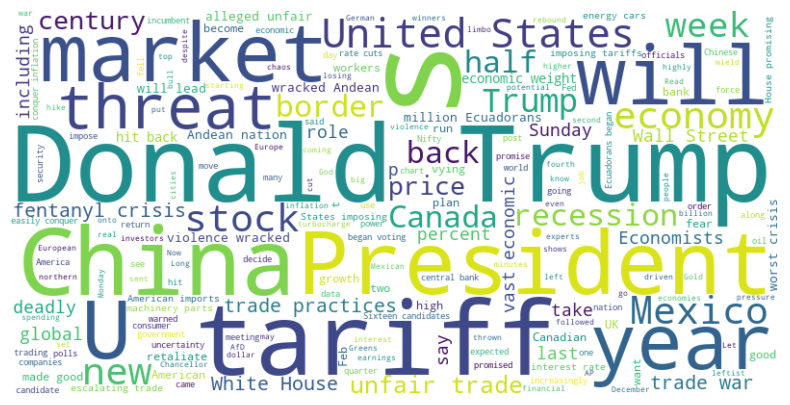

In [17]:
text = " ".join(df['description'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### word cloud for content:

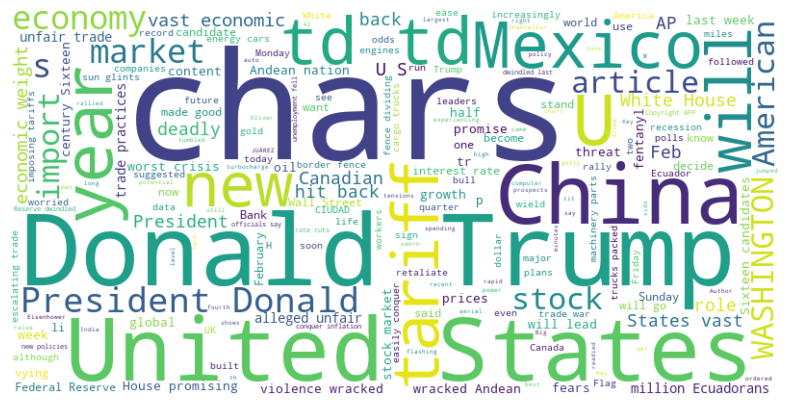

In [18]:
text = " ".join(df['content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observations:

1. In both the description and content columns, words like “Donald Trump,” “China,” and “United States” appear frequently.
2. The term “chars” appears most often in the content column, but it seems to be irrelevant data added at the end of each row. We will remove this during the data cleaning process.

## **Data Preprocessing**

### change the date format

In [19]:
df["published_date"] = df["publishedAt"].dt.date
df = df.loc[:, ["published_date", "description", "content"]]

In [20]:
df.sample(3)

published_date  \
23     2025-02-10   
77     2025-01-17   
72     2025-02-05   

                                                                                                                                                                                                                                                             description  \
23                                   Fabian Scheidler\n\n\n\nThe Greens, founded as a pacifist party, are now enthusiastic cheerleaders for rearmament.\r\n\n\r\n\n\nThe post How the Greens Became the Driving Force of German Militarism appeared first on The Nation.   
77                                                                                                                           Big Oil got its wish: Donald Trump is heading back to the White House, promising to turbocharge American fossil fuels by slashing red tape.   
72  At the meeting of the Board of Directors of Crédit Agricole S.A. on 4 february 2025, SAS Rue La Boétie informed the company of its intention to purchase Crédit Agricole S.A. shares on the market for a maximum amount of 500 million euros in line with the opera…   

                                                                                                                                                                                                                          content  
23  World / February 10, 2025\r\nThe Greens, founded as a pacifist party, are now enthusiastic cheerleaders for rearmament.\r\nAd Policy\r\nFrom left to right, Ricarda Lang, a federal chairperson of Bündnis 90… [+11271 chars]  
77       Big Oil got its wish: Donald Trump is heading back to the White House, promising to turbocharge American fossil fuels by slashing red tape.\r\nAs oil lobbyists eagerly game out how to dismantle regulat… [+8967 chars]  
72       <table><tr><td>CONTINUED STRONG EARNINGS MOMENTUM IN 2024</td></tr><tr><td>CASA AND CAG STATED AND UNDERLYING DATA Q4-2024</td></tr><tr><td>   </td><td>   </td><td>   </td><td>   </td><td>   </td><td… [+200807 chars]

#### **Preprocessing the textual columns**

Web scraped data might contain HTML tags, extra spaces, or unwanted symbols, which aren’t relevant for sentiment analysis. Therefore, we will clean the data before processing it in our model.

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
def preprocess_text(text):

    try:
        text = text.lower()
        text = re.sub(r'[^A-Za-z\s]', '', text) # Remove special characters and numbers
        words = text.split()
        text = ' '.join([ lemmatizer.lemmatize(word) for word in words]) #lemmatization
        text = ' '.join([word for word in words if word not in stopwords.words('english')]) #remove stopwords
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    except:
        text =''
        
    return text

In [23]:
def remove_char_count(text):
    text = re.sub(r'\[\+[\d]+ chars\]', '', text)
    return text

In [24]:
df['cleaned_content'] = df['content'].apply(remove_char_count)

In [25]:
df[['content','cleaned_content']].sample(3)

content  \
59    Donald Trump has followed through on his promise to wield the United States's vast economic weight to hit back at China for its alleged unfair trade practices and role in America's deadly fentanyl cr… [+5033 chars]   
60  The US has been experiencing a long "bull" stock market, that is rapid growth in stock prices, although this week tech stocks tumbled over the future prospects for US-built AI.\r\nBut could the market … [+6168 chars]   
42    Donald Trump is back in the White House, promising to use the United States’s vast economic weight to hit back at China for its alleged unfair trade practices and role in the deadly American fentanyl… [+4733 chars]   

                                                                                                                                                                                                cleaned_content  
59    Donald Trump has followed through on his promise to wield the United States's vast economic weight to hit back at China for its alleged unfair trade practices and role in America's deadly fentanyl cr…   
60  The US has been experiencing a long "bull" stock market, that is rapid growth in stock prices, although this week tech stocks tumbled over the future prospects for US-built AI.\r\nBut could the market …   
42    Donald Trump is back in the White House, promising to use the United States’s vast economic weight to hit back at China for its alleged unfair trade practices and role in the deadly American fentanyl…

In [26]:
df['cleaned_description'] = df['description'].apply(preprocess_text)
df['cleaned_content'] = df['cleaned_content'].apply(preprocess_text)

In [27]:
df[['description','cleaned_description','content','cleaned_content']].sample(3)

description  \
63                                                                                                                   OPINION: Luxon's State of the Nation speech should outline urgent, bold reform.   
68                     China has made good on its threats to retaliate in the escalating trade war with the United States, imposing tariffs on American imports of energy, cars and machinery parts.   
20  The UK economy may have shrunk in the fourth quarter, putting Britain back on the brink of recession and piling more pressure on Chancellor Rachel Reeves and her promise to turbocharge growth.   

                                                                                                                              cleaned_description  \
63                                                                                  opinion luxons state nation speech outline urgent bold reform   
68             china made good threats retaliate escalating trade war united states imposing tariffs american imports energy cars machinery parts   
20  uk economy may shrunk fourth quarter putting britain back brink recession piling pressure chancellor rachel reeves promise turbocharge growth   

                                                                                                                                                                                                                     content  \
63  Once Acts Treaty Principles Bill charade is over, Luxon will have the option of returning to Waitangi in 2026, positioning himself as a national unifier.\r\nBeehive strategists know the overwhelming ma… [+6085 chars]   
68  China has made good on its threats to retaliate in the escalating trade war with the United States, imposing tariffs on American imports of energy, cars and machinery parts.\r\nThat came just minutes a… [+4417 chars]   
20  The UK economy may have shrunk in the fourth quarter, putting Britain back on the brink of recession and piling more pressure on Chancellor Rachel Reeves and her promise to turbocharge growth.\r\nAutho… [+7868 chars]   

                                                                                                                                        cleaned_content  
63               acts treaty principles bill charade luxon option returning waitangi positioning national unifier beehive strategists know overwhelming  
68      china made good threats retaliate escalating trade war united states imposing tariffs american imports energy cars machinery parts came minutes  
20  uk economy may shrunk fourth quarter putting britain back brink recession piling pressure chancellor rachel reeves promise turbocharge growth autho

### Findout sector wise sentiment 

In [28]:
sector_keywords = {
    "Technology": ["technology", "software", "hardware", "AI", "artificial intelligence", "cloud", "semiconductor"],
    "Energy": ["energy", "oil", "gas", "renewable energy", "solar", "wind"],
    "Healthcare": ["healthcare", "pharmaceutical", "biotech", "medicine", "vaccine", "drug"],
    "Financials": ["finance", "banking", "investment", "stock", "economy", "S&P 500" , "Economists" , "trade", "inflation", "recession", "interest rates", "trading"],
    "Consumer Discretionary": ["retail", "automotive", "travel", "e-commerce"],
    "Industrials": ["manufacturing", "construction", "aviation", "defense"],
} # we can add/remove/change key and values as per our requirement, 

In [29]:
def extract_sectors(row):

    description, content = row['description'].lower(), row['content'].lower()
    sectors = []
    for sector, keywords in sector_keywords.items():
        if any(keyword in content or keyword in description for keyword in keywords):
            sectors.append(sector)
            
    if sectors == []:
        return 'Unknown'
        
    return sectors

In [30]:
df["sector"] = df[['description','content']].apply(extract_sectors,axis=1)

In [31]:
df['sector'].value_counts()

sector
[Financials]            35
Unknown                 25
[Energy, Financials]     9
[Energy]                 5
[Technology]             1
[Healthcare]             1
Name: count, dtype: int64

⬆️ We notice that there is not enough sector-specific data in the recession fear news. Instead of extracting sector data from recession-specific articles, we will fetch it separately, as the free version allows only a limited number of news articles.

### Fetch and Store Sector-Specific News:
To keep it simple, we will fetch data for three sectors in the USA: Health, Tech, and Finance. Similarly like recession fear news here again we will fetch the data once and reuse it for future runs.

In [32]:
news_url_health = f"https://newsapi.org/v2/everything?q=health+USA+care+hospital+medicine+medical&apiKey={API_KEY}"
news_url_tech = f"https://newsapi.org/v2/everything?q=tech+USA+technology+innovation+startup+AI&apiKey={API_KEY}"
news_url_finance = f"https://newsapi.org/v2/everything?q=finance+USA+stock+market+economy+investment+banking&apiKey={API_KEY}"

In [33]:
def fetch_and_store_sector_data():
    if os.path.exists(sector_specific_data):
        print("Data loaded from existing file.")
        return pd.read_csv(sector_specific_data)
    else:
        health_response = requests.get(news_url_health)
        health_news = health_response.json()
        
        tech_response = requests.get(news_url_tech)
        tech_news = tech_response.json()
        
        finance_response = requests.get(news_url_finance)
        finance_news = finance_response.json()
        
        keys_to_fetch = ["publishedAt", "description", "content"]
        filtered_health_news = [{key: d[key] for key in keys_to_fetch if key in d} for d in health_news['articles']]
        filtered_tech_news = [{key: d[key] for key in keys_to_fetch if key in d} for d in tech_news['articles']]
        filtered_finance_news = [{key: d[key] for key in keys_to_fetch if key in d} for d in finance_news['articles']]
        all_news = filtered_health_news + filtered_tech_news + filtered_finance_news
        
        data = pd.DataFrame(all_news)
        data['sector'] = ['Health'] * len(filtered_health_news) + ['Tech'] * len(filtered_tech_news) + ['Finance'] * len(filtered_finance_news)

        data.to_csv(sector_specific_data, index=False)
        print("Data fetched and saved.")
        return data

In [34]:
sector_data = fetch_and_store_sector_data()
sector_data.sample(5)

Data loaded from existing file.


publishedAt  \
67  2025-01-29T09:00:00Z   
12  2025-01-24T13:10:00Z   
26  2025-01-20T14:55:00Z   
69  2025-02-12T18:01:41Z   
70  2025-01-27T10:38:53Z   

                                                                                                                                                                                                                                                             description  \
67                                                                                           Deep Seek sorgt für Wirbel in der Tech-Welt. Mit seinem Modell R1 gelang dem chinesischen Startup DeepSeek der internationale Durchbruch. Doch wer steckt hinter der Firma?   
12       The Specialty PACS Market growth is fueled by increased adoption of advanced imaging technologies and healthcare digitalization The Specialty PACS Market growth is fueled by increased adoption of advanced imaging technologies and healthcare digitalization   
26  Advancements and Projections in the Global Pain Management Therapeutics Market: Insights, Trends, Opportunities, and Recent Developments Advancements and Projections in the Global Pain Management Therapeutics Market: Insights, Trends, Opportunities, and Recen…   
69                                                                                                                            Also in the Forbes CMO newsletter: Elon Musk’s personal brand takes a dive, Super Bowl sets viewership records, Fox buys podcast platform.   
70                                                                                                      Technology shares around the world slid on Monday as a surge in popularity of a Chinese discount artificial intelligence model shook investors' faith in the ...   

                                                                                                                                                                                                                       content  \
67  DeepSeek-Gründer Liang Wenfeng (rechts) im chinesischen Fernsehen\r\n(Bild: ShanghaiEye/YouTube)\r\nDeep Seek sorgt für Wirbel in der Tech-Welt. Mit seinem Modell R1 gelang dem chinesischen Startup DeepS… [+6547 chars]   
12   Pune, Jan. 24, 2025 (GLOBE NEWSWIRE) -- Specialty PACS Market Size &amp; Growth Analysis:\r\nAccording to SNS Insider, The Specialty PACS Market size was valued at USD 3.21 billion in 2023 and is proje… [+10664 chars]   
26   New York, Jan. 20, 2025 (GLOBE NEWSWIRE) -- Overview\r\nThe Global Pain Management Therapeutics Market is projected to reach USD 85.2 billion in 2024 which is further anticipated to reach USD 120.7 bil… [+14855 chars]   
69     This is the published version of Forbes' CMO newsletter, which offers the latest news for chief marketing officers and other messaging-focused leaders. Click here to get it delivered to your inbox ev… [+14075 chars]   
70      LONDON (Reuters) - Technology shares around the world slid on Monday as a surge in popularity of a Chinese discount artificial intelligence model shook investors' faith in the AI sector's voracious d… [+5089 chars]   

    sector  
67    Tech  
12  Health  
26  Health  
69    Tech  
70    Tech

In [35]:
sector_data.shape

(98, 4)

Clean the Data

In [36]:
sector_data['cleaned_content'] = sector_data['content'].apply(remove_char_count)
sector_data["publishedAt"] = pd.to_datetime(sector_data["publishedAt"]).dt.date

In [37]:
sector_data[['content', 'cleaned_content']].sample(3)

content  \
55    Citation: Okalany NRA, Mukunya D, Olupot-Olupot P, Chebet M, Okello F, Weeks AD, et al. (2025) Postnatal cytomegalovirus infection and its effect on hearing and neurodevelopmental outcomes among infa… [+28843 chars]   
29  Background\r\nIt is well documented that much of the evidence generated in healthcare is not effectively used in practice (known as the know-do gap).1 Knowledge translation (KT) aims to reduce this res… [+11315 chars]   
46    Citation: Park S, Marinov A, Clarke H, Schiavo S, Greer E, Djaiani G, et al. (2025) Safety of hyperbaric oxygen therapy in non-emergent patients with a history of seizures: A retrospective cohort stu… [+20632 chars]   

                                                                                                                                                                                                cleaned_content  
55    Citation: Okalany NRA, Mukunya D, Olupot-Olupot P, Chebet M, Okello F, Weeks AD, et al. (2025) Postnatal cytomegalovirus infection and its effect on hearing and neurodevelopmental outcomes among infa…   
29  Background\r\nIt is well documented that much of the evidence generated in healthcare is not effectively used in practice (known as the know-do gap).1 Knowledge translation (KT) aims to reduce this res…   
46    Citation: Park S, Marinov A, Clarke H, Schiavo S, Greer E, Djaiani G, et al. (2025) Safety of hyperbaric oxygen therapy in non-emergent patients with a history of seizures: A retrospective cohort stu…

In [38]:
sector_data['cleaned_description'] = sector_data['description'].apply(preprocess_text)
sector_data['cleaned_content'] = sector_data['cleaned_content'].apply(preprocess_text)

In [39]:
sector_data[['description', 'cleaned_description', 'content', 'cleaned_content']].sample(3)

description  \
6                                                                                             It's been about five years since the first case of COVID-19 was confirmed in Australia. This is what Australia living through "unprecedented times" looks like in numbers.   
44  Perinatal mental health disorders are a significant contributor to morbidity and mortality in childbearing women. The World Health Organization recommends all women be screened for mental health disorders postnatally and have diagnostic and management service…   
68                                                                                                                                                                       Offene Fragen zum chinesischen Startup verhindern eine nüchterne Beurteilung seiner Innovation.   

                                                                                                                                                                                                       cleaned_description  \
6                                                                                                            five years since first case covid confirmed australia australia living unprecedented times looks like numbers   
44  perinatal mental health disorders significant contributor morbidity mortality childbearing women world health organization recommends women screened mental health disorders postnatally diagnostic management service   
68                                                                                                                           offene fragen zum chinesischen startup verhindern eine nchterne beurteilung seiner innovation   

                                                                                                                                                                                                                        content  \
6   Tomorrow marks five years since the first case of COVID-19 was confirmed in Australia.\r\nThe country was in the midst of the catastrophic Black Summer bushfires. \r\nSo, reports about a mystery virus sp… [+25063 chars]   
44    Abstract\r\nPerinatal mental health disorders are a significant contributor to morbidity and mortality in childbearing women. The World Health Organization recommends all women be screened for mental h… [+28366 chars]   
68       Nichts schüttelte die Tech-Welt in den vergangenen Jahren so stark durch wie das Sprachmodell R1 des chinesischen Startups Deepseek. Endlich ein Open-Source-Modell, das mit den amerikanischen Branche… [+7121 chars]   

                                                                                                                                                                               cleaned_content  
6                                              tomorrow marks five years since first case covid confirmed australia country midst catastrophic black summer bushfires reports mystery virus sp  
44                      abstract perinatal mental health disorders significant contributor morbidity mortality childbearing women world health organization recommends women screened mental h  
68  nichts schttelte die techwelt den vergangenen jahren stark durch wie das sprachmodell r des chinesischen startups deepseek endlich ein opensourcemodell das mit den amerikanischen branche

To determine the sentiment of the news, we can use the content, description, or both. I will merge both features and predict sentiment based on the combined text. Ideally, a longer text helps in better market analysis, but since both have similar lengths, we will merge them for this version.

In [40]:
sector_data['text'] = sector_data['cleaned_description'].fillna('') + ' ' + sector_data['cleaned_content'].fillna('')
sector_data = sector_data.loc[:,['publishedAt','text','sector']]

In [41]:
sector_data.sample(5)

publishedAt  \
6   2025-01-23   
2   2025-01-28   
22  2025-02-07   
36  2025-01-27   
10  2025-01-24   

                                                                                                                                                                                                                                                                                                                                                                                                                          text  \
6                                                                                                                                                                five years since first case covid confirmed australia australia living unprecedented times looks like numbers tomorrow marks five years since first case covid confirmed australia country midst catastrophic black summer bushfires reports mystery virus sp   
2   background medication adherence plays crucial role effectively managing hypertension significant public health concern especially regions like central vietnam study aimed assess medication adherence levels among hypertensive patients p citation anh hien h tam nm van minh h binh thang phuoc hoang l heytens et al factors influencing medication adherence among hypertensive patients primary care settings centra   
22                                           rise prevalence acute chronic disorders increase geriatric population increase initiatives awareness education use suppositories drive growth pharmaceutical suppositories market rise prevalence acute wilmington delaware feb globe newswire allied market research published report titled pharmaceutical suppositories market type rectal suppositories vaginal suppositories   
36                   introduction selfharm represents complex multifaceted public health issue global significance exerting profound effects individuals communities alike involves intentional selfpoisoning selfinjury without motivation di abstract introduction selfharm represents complex multifaceted public health issue global significance exerting profound effects individuals communities alike involves intenti   
10                                     previous research indicates covid pandemic catalyzed alterations behaviors may impact exposures environmental endocrinedisrupting chemicals includes changes use chemicals found consumer products food packaging abstract previous research indicates covid pandemic catalyzed alterations behaviors may impact exposures environmental endocrinedisrupting chemicals includes changes   

    sector  
6   Health  
2   Health  
22  Health  
36  Health  
10  Health

# Step2:
  ### In this step we will choose the an encoder and find sentiment for all the news:

## **Sentiment Analysis**

We will start with **FinBERT** model from hugging face.

**Why this model:**
- The encoder architecture is highly efficient for sentiment analysis, which aligns with our goal.
- The model is already trained on financial data, making it well-suited for our specific financial task.

**Anticipated Problem:**
- We need to predict market recession, but this model is not specifically trained on recession data. It was created to predict generic financial sentiment.
- The model predicts positive when the financial situation of the market is good and negative when the market is down. However, our goal is to mark it as positive when a recession is imminent and negative when the market is not prone to a recession, which is the opposite of the model’s current behavior. We need to handle this mismatch.

In [42]:
model_name = "yiyanghkust/finbert-tone"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

Lets check the order of the sentiment classes for this model:

In [43]:
labels = model.config.id2label
print(labels)

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}


✅ When FinBERT predicts a positive score, it generally means the market or the sentiment around a financial topic is optimistic or favorable. This often suggests that the market is expected to rise or that investors have a positive outlook. However, our expectation is the opposite: in the case of a recession, the model should predict a positive score. We will keep the sentiment label for “neutral” as is, and reverse the sentiment labels for “positive” and “negative.”

- New sentiment logic of the FinBERT model is:
    - Positive Score (2): Indicates fear of recession.
    - Neutral Score (0): Indicating no strong signs either way, which will be same as finbert original logic.
    - Negative Score (1): Indicates recession safe.

In [44]:
sentiments = {0: 'Neutral', 1: 'Negative', 2: 'Positive'} # reversing the existing Finbert Logic

In [45]:
def predict_sentiment(text):
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    neutral_confidence = probabilities[0][0].item()  # 0 is Neutral
    negative_confidence = probabilities[0][1].item()   # 1 is Negative
    positive_confidence = probabilities[0][2].item()  # 2 is Positive

    sentiment_idx = torch.argmax(probabilities).item()
    predicted_sentiment = sentiments[sentiment_idx]
    confidence = probabilities[0][sentiment_idx].item()
    
    return predicted_sentiment, confidence

In [46]:
df[['description_sentiment', 'description_confidence']] = df['cleaned_description'].apply(lambda x: pd.Series(predict_sentiment(x)))
df[['content_sentiment', 'content_confidence']] = df['cleaned_content'].apply(lambda x: pd.Series(predict_sentiment(x)))

In [47]:
df[['cleaned_description','description_sentiment','description_confidence','cleaned_content','content_sentiment','content_confidence']].sample(3)

cleaned_description  \
6                                                                                                                                   discuss trumps weaponisation us power poses threat peace prosperity planet   
50  million ecuadorans began voting tight security sunday choosing lead violencewracked andean nation worst crisis half century sixteen candidates vying become president including hawkish young incumbent da   
68                                                                          china made good threats retaliate escalating trade war united states imposing tariffs american imports energy cars machinery parts   

   description_sentiment  description_confidence  \
6               Positive                0.844166   
50               Neutral                0.999165   
68              Negative                0.952632   

                                                                                                                                          cleaned_content  \
6              yves seemed appropriate go news flow thus provide extra helping trump coverage please filter upset opening paragraphs right wing around wo   
50  military personnel stand guard women queue vote polling station canuto ecuador february presidential election copyright afp rodrigo buendia million e   
68        china made good threats retaliate escalating trade war united states imposing tariffs american imports energy cars machinery parts came minutes   

   content_sentiment  content_confidence  
6            Neutral            0.998930  
50           Neutral            0.999993  
68          Negative            0.999971

Now that we have generated sentiment, let’s identify the most frequently used words in positive (recession fear) and negative (recession safe) news.

In [48]:
def top20_positive_negative_words(news_content, label):

    positive_text = " ".join(df[df[label] == 'Positive'][news_content])
    negative_text = " ".join(df[df[label] == 'Negative'][news_content])
    
    pos_words = Counter(positive_text.split()).most_common(20)
    neg_words = Counter(negative_text.split()).most_common(20)
    
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # First barplot for Positive Words
    sns.barplot(x=[x[1] for x in pos_words], y=[x[0] for x in pos_words], ax=axes[0])
    axes[0].set_title("Top 20 Words in Recession Fear News")
    
    # Second barplot for Negative Words
    sns.barplot(x=[x[1] for x in neg_words], y=[x[0] for x in neg_words], ax=axes[1])
    axes[1].set_title("Top 20 Words in Economic Optimism News")
    
    plt.tight_layout()
    plt.show()

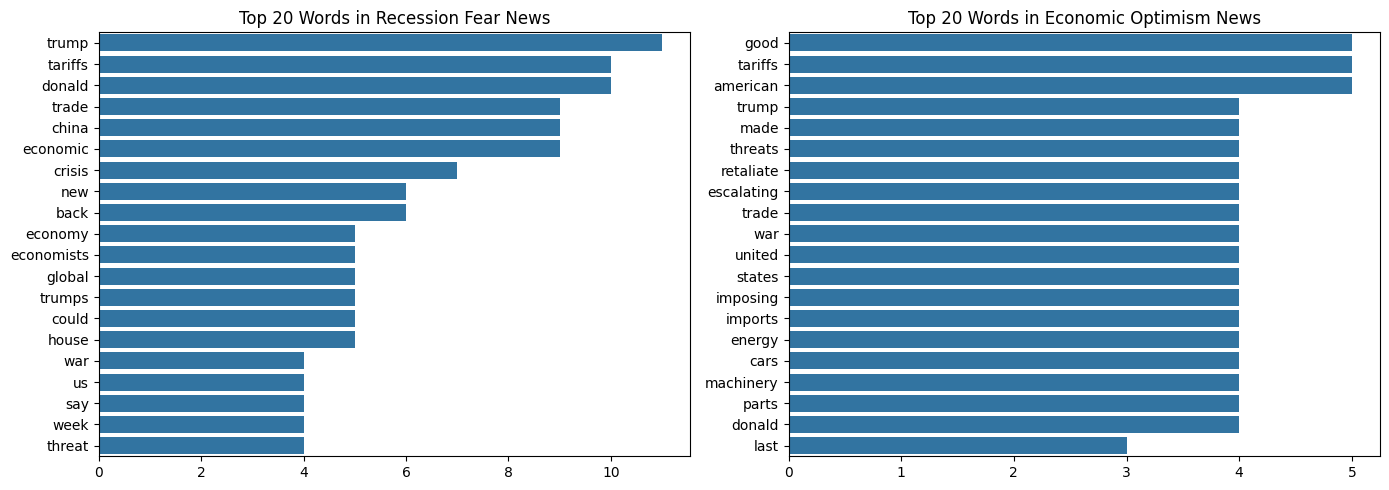

In [49]:
top20_positive_negative_words('cleaned_description', 'description_sentiment')

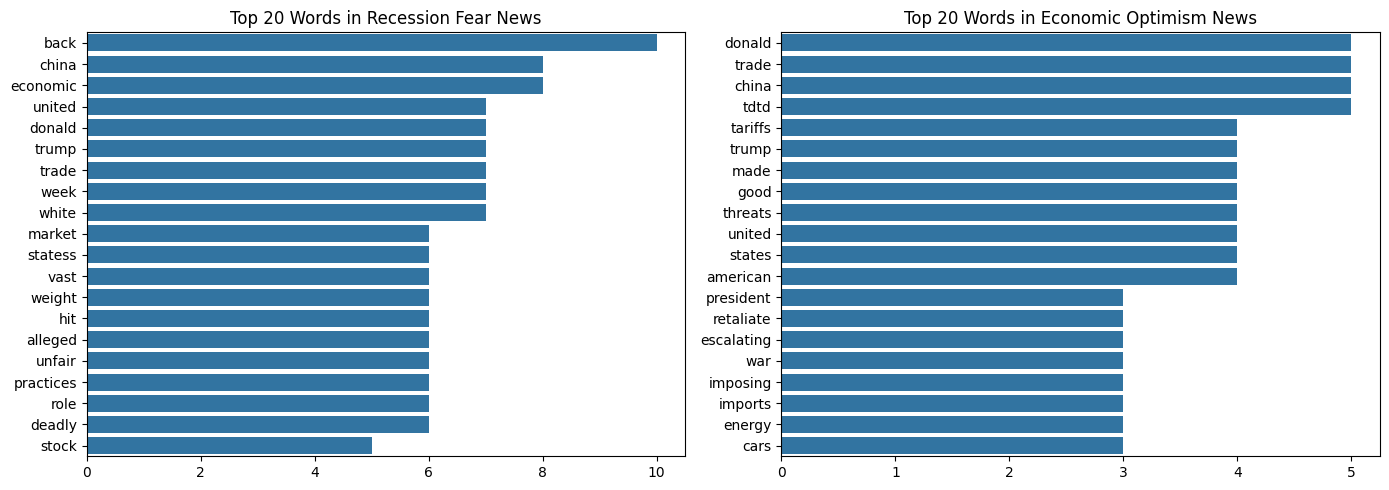

In [50]:
top20_positive_negative_words('cleaned_content', 'content_sentiment')

In the previous graph, we observed that words in positive-scored news appear more frequently than in negative-scored news. To understand this better, let’s check the news count for each sentiment score.

In [51]:
def labeled_barplot(column_name, title, palette='Paired'):

    count = df[column_name].nunique()
    plt.figure(figsize=(count + 1, 5))

    ax = sns.countplot(x=df[column_name], palette=palette)
    ax.set_title(title)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

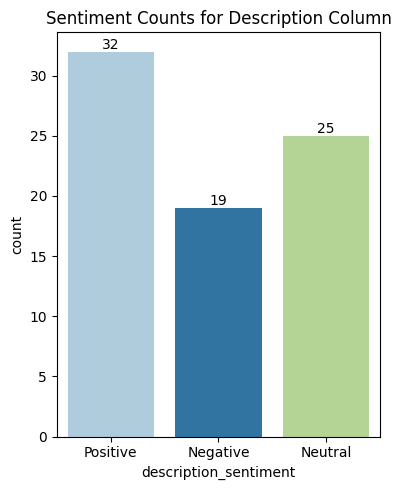

In [52]:
labeled_barplot('description_sentiment','Sentiment Counts for Description Column')

Using the "description" feature to predict sentiment results in:
- 32 Positive or Recession Fear news
- 19 Recession Safe news
- 25 Neutral news

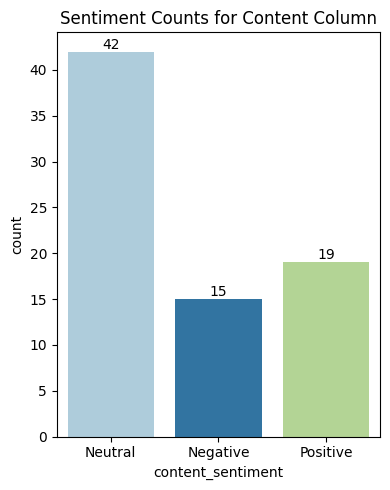

In [53]:
labeled_barplot('content_sentiment','Sentiment Counts for Content Column')

Using the "Content" feature to predict sentiment results in:
- 15 Positive or Recession Fear news
- 19 Recession Safe news
- 42 Neutral news

This is expected since the “Content” feature contains only the first few lines, making it harder to determine the full sentiment of the news. For better results, we will combine both features and predict sentiment again.

In [54]:
df['news'] = df['cleaned_description'] + ' ' + df['cleaned_content']
df[['overall_sentiment', 'sentiment_confidence']] = df['news'].apply(lambda x: pd.Series(predict_sentiment(x)))

In [55]:
df[['cleaned_description','description_sentiment','description_confidence','cleaned_content','content_sentiment','content_confidence','news','overall_sentiment','sentiment_confidence']].sample(3)

cleaned_description  \
12                                               nearly men stand adversity want test mans character give power abraham lincoln th president united states driven mission god god would tell post us government   
7                                                                                   donald trumps new tariffs canada mexico china shocked financial markets economists say move thrown global trade order chaos   
66  president donald trumps threats impose tariffs mexico canada left many cities along mexicos northern border limbo border factories manufacture goods headed us vital part transnational economic machine ge   

   description_sentiment  description_confidence  \
12               Neutral                0.999991   
7               Positive                0.999425   
66               Neutral                0.999357   

                                                                                                                                                           cleaned_content  \
12                                                     nearly men stand adversity want test mans character give power abraham lincoln th president united states driven mi   
7   global stock markets dived dollar rallied oil prices jumped world leaders readied titfortat measures almost immediate reactions us president donald trumps new tariffs   
66                         employees work textile factory tlaxcala mexico tuesday feb eduardo verdugoap us border mexico seen aerial view friday jan near san diegojae c h   

   content_sentiment  content_confidence  \
12           Neutral            0.999995   
7            Neutral            0.932459   
66           Neutral            0.999999   

                                                                                                                                                                                                                                                                                                                                                           news  \
12                                                                           nearly men stand adversity want test mans character give power abraham lincoln th president united states driven mission god god would tell post us government nearly men stand adversity want test mans character give power abraham lincoln th president united states driven mi   
7                                                            donald trumps new tariffs canada mexico china shocked financial markets economists say move thrown global trade order chaos global stock markets dived dollar rallied oil prices jumped world leaders readied titfortat measures almost immediate reactions us president donald trumps new tariffs   
66  president donald trumps threats impose tariffs mexico canada left many cities along mexicos northern border limbo border factories manufacture goods headed us vital part transnational economic machine ge employees work textile factory tlaxcala mexico tuesday feb eduardo verdugoap us border mexico seen aerial view friday jan near san diegojae c h   

   overall_sentiment  sentiment_confidence  
12           Neutral              0.999989  
7           Positive              0.904807  
66           Neutral              0.999988

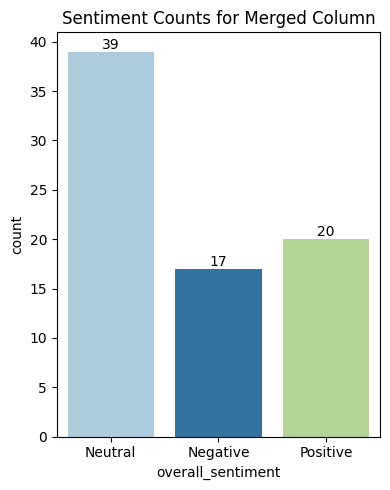

In [56]:
labeled_barplot('overall_sentiment','Sentiment Counts for Merged Column')

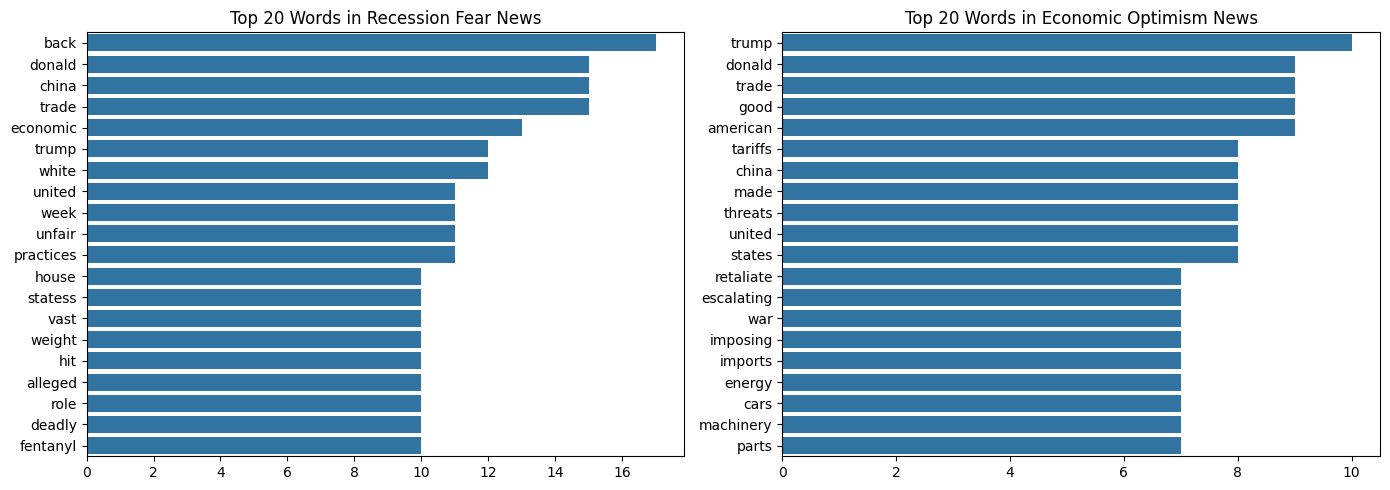

In [57]:
top20_positive_negative_words('news', 'overall_sentiment')

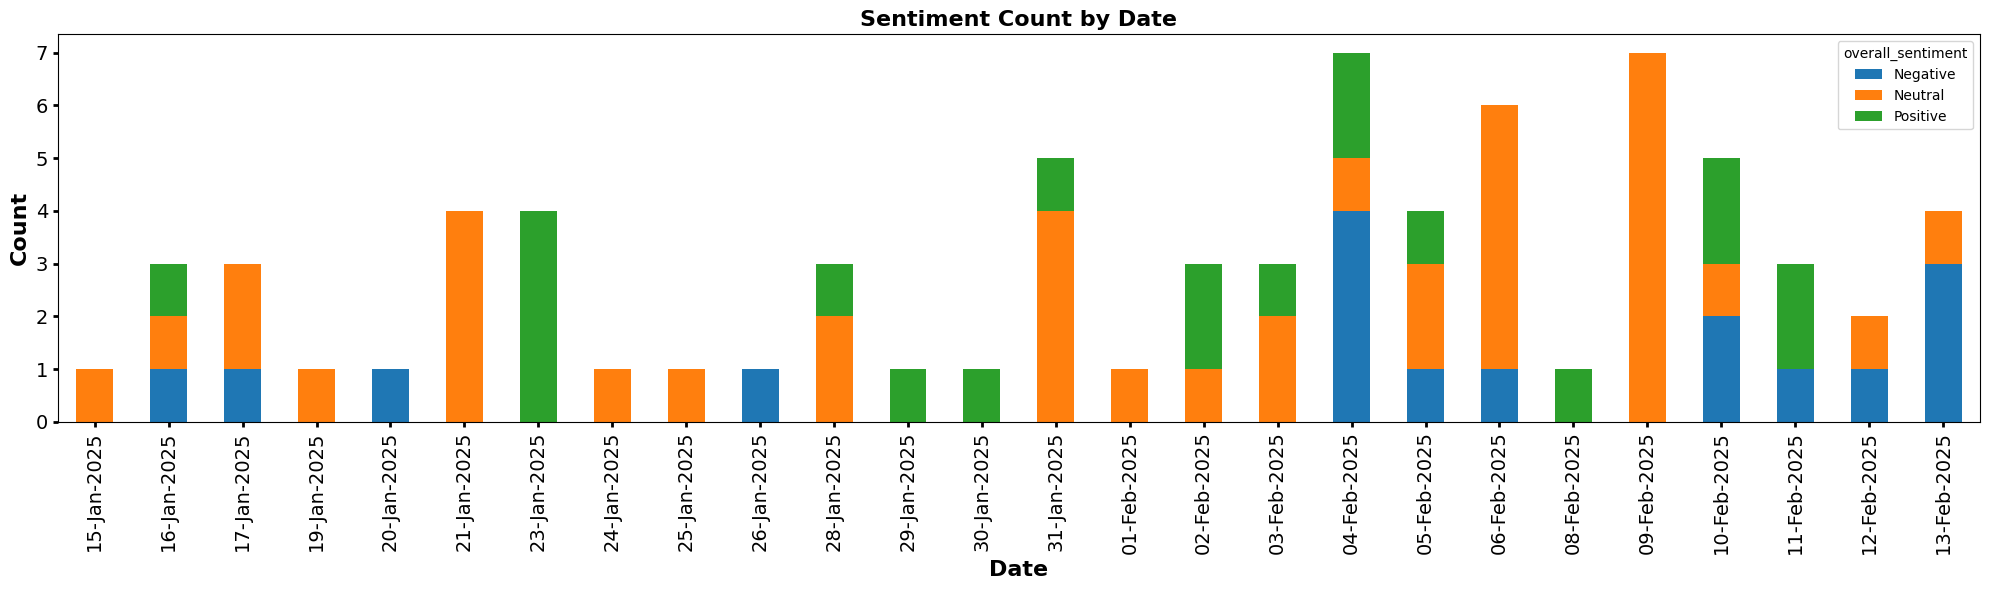

In [58]:
sentiment_counts = df.groupby([df['published_date'], 'overall_sentiment']).size().unstack(fill_value=0)
sentiment_counts.index = pd.to_datetime(sentiment_counts.index)
formatted_dates = sentiment_counts.index.strftime('%d-%b-%Y')

ax = sentiment_counts.plot(kind='bar', stacked=True, figsize=(20, 6))
ax.set_xticks(range(len(sentiment_counts)))
ax.set_xticklabels(formatted_dates, rotation=90)

plt.title('Sentiment Count by Date', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')
ax.tick_params(axis='both', labelsize=14, width=2)

plt.tight_layout()
plt.show()

### Observation:

The graph shows the number of news articles received each day and their sentiment distribution (positive, negative, and neutral). This helps us understand the overall sentiment trend for each day—whether it was mostly negative, positive, or neutral.

We will remove redundant columns to make the dataframe easier to read and use.

In [59]:
df = df.loc[:, ['published_date','news','overall_sentiment','sentiment_confidence']]

In [60]:
df.sample(3)

published_date  \
14     2025-01-28   
66     2025-02-06   
30     2025-02-03   

                                                                                                                                                                                                                                                                                                                                                                                                news  \
14  scandalous daily links imitative chimp peeing heating oceans hn reassortment china output fall niger blood oil afd alignment uk job cuts iran hawks losing russia take trump bluster feds lose warranteless searches trump spending freeze e peeing socially contagious chimps media general dwight eisenhower foresight realize holocaust denial would occur eisenhower said get record get fil   
66                                       president donald trumps threats impose tariffs mexico canada left many cities along mexicos northern border limbo border factories manufacture goods headed us vital part transnational economic machine ge employees work textile factory tlaxcala mexico tuesday feb eduardo verdugoap us border mexico seen aerial view friday jan near san diegojae c h   
30                                donald trumps new tariffs canada mexico china sent shockwaves financial markets economists warned move thrown global trade order chaos global stock markets dived dollar rallied oil prices jumped global stock markets dived dollar rallied oil prices jumped titfortat measures readied almost immediate reactions us president donald trumps new tariffs canada   

   overall_sentiment  sentiment_confidence  
14           Neutral              0.993694  
66           Neutral              0.999988  
30           Neutral              0.952354

## Find the Weighted sentiment for every day

In [61]:
news_df = df.copy()

In the FinBERT model, neutral sentiment is represented as zero. However, if we keep it as zero when calculating the weighted average, the result will also be zero, causing the confidence score to have no impact. To address this, we will assign a very small value to the neutral sentiment, allowing us to calculate a meaningful weighted value.

In [62]:
sentiment_mapping = {'Positive': 1, 'Neutral': 0.00001, 'Negative': -1}

In [63]:
news_df['sentiment'] = news_df['overall_sentiment'].map(sentiment_mapping)

In [64]:
news_df.sample(2)

published_date  \
14     2025-01-28   
33     2025-02-10   

                                                                                                                                                                                                                                                                                                                                                                                                news  \
14  scandalous daily links imitative chimp peeing heating oceans hn reassortment china output fall niger blood oil afd alignment uk job cuts iran hawks losing russia take trump bluster feds lose warranteless searches trump spending freeze e peeing socially contagious chimps media general dwight eisenhower foresight realize holocaust denial would occur eisenhower said get record get fil   
33                  incumbent president daniel noboa monday clutched onto razorthin lead violencehit ecuadors election strongerthanexpected leftist challenger looked set force secondround runoff percent ballots counted incumbent president daniel noboa monday clutched onto razorthin lead violencehit ecuadors election strongerthanexpected leftist challenger looked set force secondround r   

   overall_sentiment  sentiment_confidence  sentiment  
14           Neutral              0.993694    0.00001  
33          Negative              0.999923   -1.00000

In [65]:
news_df['weighted_sentiment'] = news_df['sentiment'] * news_df['sentiment_confidence']
weighted_news_df = news_df.groupby('published_date').agg(
    total_weighted_sentiment=('weighted_sentiment', 'sum'),
    total_confidence=('sentiment_confidence', 'sum')
).reset_index()

In [66]:
weighted_news_df.head(5)

published_date  total_weighted_sentiment  total_confidence
0     2025-01-15                  0.000010          0.999160
1     2025-01-16                  0.011661          2.988085
2     2025-01-17                 -0.831864          2.809898
3     2025-01-19                  0.000007          0.732223
4     2025-01-20                 -0.999998          0.999998

In [67]:
weighted_news_df['weighted_sentiment'] = weighted_news_df['total_weighted_sentiment'] / weighted_news_df['total_confidence']

weighted_news_df = weighted_news_df[['published_date', 'weighted_sentiment']]
weighted_news_df.columns = ['Date', 'weighted_sentiment']

In [68]:
weighted_news_df.head(5)

Date  weighted_sentiment
0  2025-01-15            0.000010
1  2025-01-16            0.003902
2  2025-01-17           -0.296048
3  2025-01-19            0.000010
4  2025-01-20           -1.000000

### Sector Specific Sentiment Analysis

We downloaded sector-specific data separately. Now, we will analyze its sentiment and examine how sentiment impacts different sectors.

In [69]:
sector_data[['sentiment', 'confidence_score']] = sector_data['text'].apply(lambda x: pd.Series(predict_sentiment(x)))

In [70]:
sector_data.sample(2)

publishedAt  \
62  2025-01-30   
50  2025-02-13   

                                                                                                                                                                                                                                                                                                                                                                                                         text  \
62                                                                         abstract express support opinion models purport calculate mortality infant mortality particular averted vaccine programmes invalid based inputs vaccine efficacy pathogen prevalence viru abstract express support opinion models purport calculate mortality infant mortality particular averted vaccine programmes invalid based   
50  background infertility affects one six people globally similar prevalence rates across highincome low middleincome countries technological advancements particularly assisted reproductive technology art improved fertility treat citation njagi p groot w arsenijevic j mburu g chambers g calhazjorge c et al financial cost assisted reproductive technology patients highincome countries systematic   

    sector sentiment  confidence_score  
62  Health   Neutral          0.999812  
50  Health   Neutral          0.999889

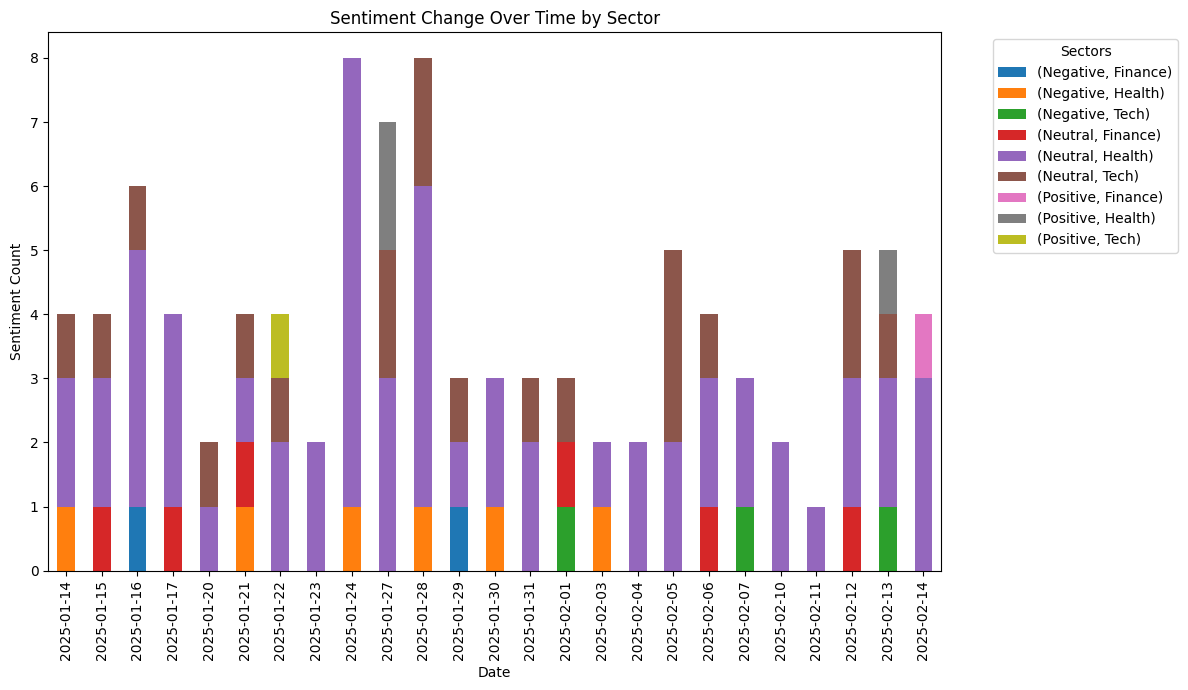

In [71]:
sentiment_counts = sector_data.groupby([sector_data['publishedAt'], 'sector', 'sentiment']).size().unstack(fill_value=0)
pivoted_data = sentiment_counts.pivot_table(index='publishedAt', columns='sector', values=['Positive', 'Negative', 'Neutral'], aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(12, 7))
pivoted_data.plot(kind='bar', stacked=True, ax=ax)

plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Change Over Time by Sector')
plt.xticks(rotation=90)
plt.legend(title='Sectors', fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()

### Observation:

For all three sectors, we observe that the majority of the news is neutral, with very few recession fear-related news (only one per sector).

# Step3:
  ### Download Market Data and Visualization of Market vs Sentiment:

### Download S&P 500 index data for the same date range as our news data fetched via the API.

✅ We will analyze if sentiment scores impact the actual market. First, we’ll identify the dates for which we have news and fetch the S&P 500 data for that date range.

In [72]:
start_date = weighted_news_df['Date'].min()
end_date = weighted_news_df['Date'].max()

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

Start Date: 2025-01-15
End Date: 2025-02-13


In [73]:
ticker = "^GSPC"  # S&P 500 index
market_data = yf.download(ticker, start=start_date, end=end_date)
market_data.reset_index(inplace=True)
market_data.columns = [col[0] for col in market_data.columns]
market_data.head(2)


*********************100%***********************]  1 of 1 completed

Date    Adj Close        Close         High          Low         Open  \
0 2025-01-15  5949.910156  5949.910156  5960.609863  5905.209961  5905.209961   
1 2025-01-16  5937.339844  5937.339844  5964.689941  5930.720215  5963.609863   

       Volume  
0  4544570000  
1  4285810000

In [74]:
yahoo_start_date = market_data['Date'].min()
yahoo_end_date = market_data['Date'].max()

print(f"Start Date: {yahoo_start_date}")
print(f"End Date: {yahoo_end_date}")

Start Date: 2025-01-15 00:00:00
End Date: 2025-02-12 00:00:00


Since our main task is to analyze recession fear sentiment, we will also download VIX data to examine how news sentiment affects the VIX.

In [75]:
vix_data = yf.download("^VIX", start=start_date, end=end_date, interval="1d")
vix_data.reset_index(inplace=True)
vix_data.columns = [col[0] for col in vix_data.columns]
vix_data.head(2)


*********************100%***********************]  1 of 1 completed

Date  Adj Close      Close       High    Low   Open  Volume
0 2025-01-15  16.120001  16.120001  19.139999  15.96  19.08       0
1 2025-01-16  16.600000  16.600000  16.600000  15.64  15.87       0

In [76]:
print(f"Start Date: {vix_data['Date'].min()}")
print(f"End Date: {vix_data['Date'].max()}")

Start Date: 2025-01-15 00:00:00
End Date: 2025-02-12 00:00:00


## Merge Market Data with Sentiment

In [77]:
market_data.dtypes

Date         datetime64[ns]
Adj Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume                int64
dtype: object

In [78]:
market_data['Date'] = market_data['Date'].dt.date

In [79]:
market_data.sample(3)

Date    Adj Close        Close         High          Low  \
2  2025-01-17  5996.660156  5996.660156  6014.959961  5978.439941   
1  2025-01-16  5937.339844  5937.339844  5964.689941  5930.720215   
3  2025-01-21  6049.240234  6049.240234  6051.509766  6006.879883   

          Open      Volume  
2  5995.399902  4366830000  
1  5963.609863  4285810000  
3  6014.120117  4702920000

In [80]:
print(f"yahoo data size before merging:{market_data.shape}")
print(f"news data size before merging:{weighted_news_df.shape}")

yahoo data size before merging:(20, 7)
news data size before merging:(26, 2)


In [81]:
merged_df = pd.merge(market_data, weighted_news_df, on='Date', how='inner')

In [82]:
merged_df.sample(3)

Date    Adj Close        Close         High          Low  \
9   2025-01-31  6040.529785  6040.529785  6120.910156  6030.930176   
16  2025-02-12  6051.970215  6051.970215  6063.000000  6003.000000   
5   2025-01-24  6101.240234  6101.240234  6128.180176  6088.740234   

           Open      Volume  weighted_sentiment  
9   6096.790039  4843770000            0.219311  
16  6025.080078  4627960000           -0.355437  
5   6121.430176  4214250000            0.000010

In [83]:
print(f"merged data size of yahoo and news after inner join:{merged_df.shape}")

merged data size of yahoo and news after inner join:(17, 8)


Prepare Data For Analysis:

In [84]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values('Date')

merged_df['prev_close'] = merged_df['Close'].shift(1)
merged_df['prev_weight'] = merged_df['weighted_sentiment'].shift(1)
merged_df['close_change'] =  merged_df['Close'] - merged_df['prev_close']
merged_df['open_change'] =  merged_df['Open'] - merged_df['prev_close']
merged_df['sentiment_change'] = merged_df['weighted_sentiment'] - merged_df['prev_weight']

In [85]:
merged_df.head(5)

Date    Adj Close        Close         High          Low         Open  \
0 2025-01-15  5949.910156  5949.910156  5960.609863  5905.209961  5905.209961   
1 2025-01-16  5937.339844  5937.339844  5964.689941  5930.720215  5963.609863   
2 2025-01-17  5996.660156  5996.660156  6014.959961  5978.439941  5995.399902   
3 2025-01-21  6049.240234  6049.240234  6051.509766  6006.879883  6014.120117   
4 2025-01-23  6118.709961  6118.709961  6118.729980  6074.669922  6076.319824   

       Volume  weighted_sentiment   prev_close  prev_weight  close_change  \
0  4544570000            0.000010          NaN          NaN           NaN   
1  4285810000            0.003902  5949.910156     0.000010    -12.570312   
2  4366830000           -0.296048  5937.339844     0.003902     59.320312   
3  4702920000            0.000010  5996.660156    -0.296048     52.580078   
4  4432250000            1.000000  6049.240234     0.000010     69.469727   

   open_change  sentiment_change  
0          NaN               NaN  
1    13.699707          0.003892  
2    58.060059         -0.299950  
3    17.459961          0.296058  
4    27.079590          0.999990

In [86]:
merged_df['sentiment_change1'] = merged_df['sentiment_change'].shift(1)

In [87]:
merged_df.head(5)

Date    Adj Close        Close         High          Low         Open  \
0 2025-01-15  5949.910156  5949.910156  5960.609863  5905.209961  5905.209961   
1 2025-01-16  5937.339844  5937.339844  5964.689941  5930.720215  5963.609863   
2 2025-01-17  5996.660156  5996.660156  6014.959961  5978.439941  5995.399902   
3 2025-01-21  6049.240234  6049.240234  6051.509766  6006.879883  6014.120117   
4 2025-01-23  6118.709961  6118.709961  6118.729980  6074.669922  6076.319824   

       Volume  weighted_sentiment   prev_close  prev_weight  close_change  \
0  4544570000            0.000010          NaN          NaN           NaN   
1  4285810000            0.003902  5949.910156     0.000010    -12.570312   
2  4366830000           -0.296048  5937.339844     0.003902     59.320312   
3  4702920000            0.000010  5996.660156    -0.296048     52.580078   
4  4432250000            1.000000  6049.240234     0.000010     69.469727   

   open_change  sentiment_change  sentiment_change1  
0          NaN               NaN                NaN  
1    13.699707          0.003892                NaN  
2    58.060059         -0.299950           0.003892  
3    17.459961          0.296058          -0.299950  
4    27.079590          0.999990           0.296058

In [88]:
merged_df['sentiment_change2'] = merged_df['sentiment_change1'].shift(1)

In [89]:
merged_df.head(5)

Date    Adj Close        Close         High          Low         Open  \
0 2025-01-15  5949.910156  5949.910156  5960.609863  5905.209961  5905.209961   
1 2025-01-16  5937.339844  5937.339844  5964.689941  5930.720215  5963.609863   
2 2025-01-17  5996.660156  5996.660156  6014.959961  5978.439941  5995.399902   
3 2025-01-21  6049.240234  6049.240234  6051.509766  6006.879883  6014.120117   
4 2025-01-23  6118.709961  6118.709961  6118.729980  6074.669922  6076.319824   

       Volume  weighted_sentiment   prev_close  prev_weight  close_change  \
0  4544570000            0.000010          NaN          NaN           NaN   
1  4285810000            0.003902  5949.910156     0.000010    -12.570312   
2  4366830000           -0.296048  5937.339844     0.003902     59.320312   
3  4702920000            0.000010  5996.660156    -0.296048     52.580078   
4  4432250000            1.000000  6049.240234     0.000010     69.469727   

   open_change  sentiment_change  sentiment_change1  sentiment_change2  
0          NaN               NaN                NaN                NaN  
1    13.699707          0.003892                NaN                NaN  
2    58.060059         -0.299950           0.003892                NaN  
3    17.459961          0.296058          -0.299950           0.003892  
4    27.079590          0.999990           0.296058          -0.299950

Analysis of how sentiment affects the market using various visualization techniques:

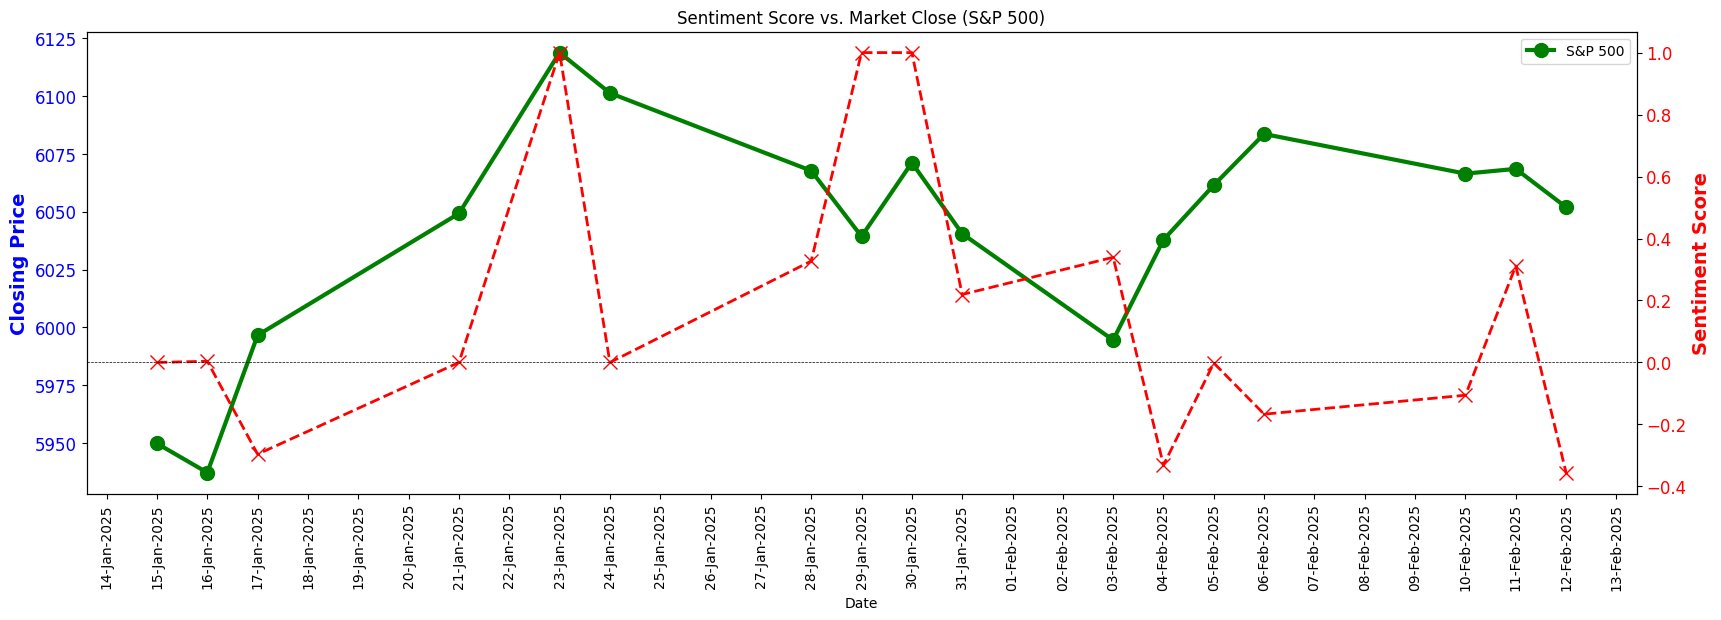

In [90]:
fig, ax1 = plt.subplots(figsize=(20, 6))

ax1.plot(merged_df['Date'], merged_df['Close'], color='green', label='S&P 500', linewidth=3, marker='o', markersize=10)

ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)

ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(merged_df['Date'], merged_df['weighted_sentiment'], color='red', linestyle='dashed', linewidth=2, marker='x', markersize=10)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.set_ylabel('Sentiment Score', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
ax1.tick_params(axis='x', rotation=90)

plt.title('Sentiment Score vs. Market Close (S&P 500)')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.show()

### Observation:

Sentiment score can have an immediete impact on the market on the same day due to some major event or it can have an impact with lag of 1-2 days or longer as market might take longer to digest news. 

In above chart there are noticeable instances where sentiment scores (red dashed line) seem to lead or align with S&P 500 movements (green solid line). 

For example, a sharp rise in sentiment score around January 17-23, 2025, aligns with drop in the index value over next few days between Jan 23-29. Similarly, a drop around Jan 30- Feb 4, 2025, coincides with the index moving higher over next few days between Feb 3 - 7.

In the subsequent sections we will try to explore further impact of sentiment score on intraday price action and gap up/ gap down of index prices.

In [91]:
fig = make_subplots(
    specs=[[{"secondary_y": True}]],
    shared_xaxes=True,
)

fig.add_trace(go.Candlestick(
    x=merged_df['Date'],
    open=merged_df['Open'],
    high=merged_df['High'],
    low=merged_df['Low'],
    close=merged_df['Close'],
    name="S&P 500"
), secondary_y=False)

fig.add_trace(go.Scatter(
    x=merged_df['Date'],
    y=merged_df['weighted_sentiment'],
    mode='lines+markers',
    name="Sentiment",
    line=dict(color='red', width=2, dash='dash')
), secondary_y=True)

fig.update_layout(
    title="Candlestick Chart with Sentiment Score",
    xaxis_title="Date",
    yaxis_title="S&P 500 Price",
    xaxis_rangeslider_visible=False,
    width=1500,
    height=400,
    yaxis2=dict(
        overlaying='y',
        side='right',
        title="Sentiment Score",
        tickformat=".1f",
        showgrid=True,
        zeroline=True,
        zerolinecolor='gray',
        zerolinewidth=1.5,
        mirror=True,
        showline=True,
        linecolor='black',  
        linewidth=0.01
    ),
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    xaxis=dict(
        tickmode='linear',
        dtick="D1",
        tickformat='%d-%b-%Y',
        tickangle=-90,
        showgrid=True,
        mirror=True,
        showline=True,
        linecolor='black',
        linewidth=.01
    )
)

fig.show()

### Observation:

This is a consolidated chart that displays the Open, Close, High, and Low values along with the sentiment score. Similar to the previous  graph, this chart helps us understand how market sentiment impacts the S&P 500 values. You can hover over the graph for more details.

We clearly see that apart from impact on daily closing price change , there might be a relation between sentiment score change and gap up/gap down in index opening price and also on intraday price action seen through green & red candle. 

For instance 16-21 Jan period has low sentiment score which is positive and we see gap ups and strong green candles on 21-22 jan. 

There is a sharp rise sentiment score on 23rd jan which is followed by red candle and gap downs in subsequent days. 

Due to limited availibility of data (less than 1 month) its difficult to spot a perfect correlation between sentiment score and index price.

But to be sure if sentiment score has an immediete impact or has an impact with a lag we will plot scatter plot of sentiment change vs price change in next section 

## Correlation With Market Move:

In [92]:
def plot_scatter(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, c=y, cmap='coolwarm', alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

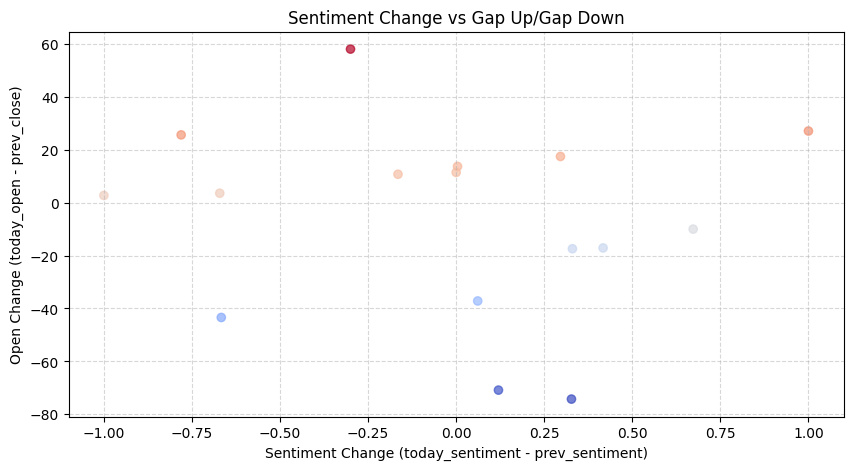

In [93]:
plot_scatter(merged_df['sentiment_change'], merged_df['open_change'], "Sentiment Change (today_sentiment - prev_sentiment)", 
                "Open Change (today_open - prev_close)", "Sentiment Change vs Gap Up/Gap Down")

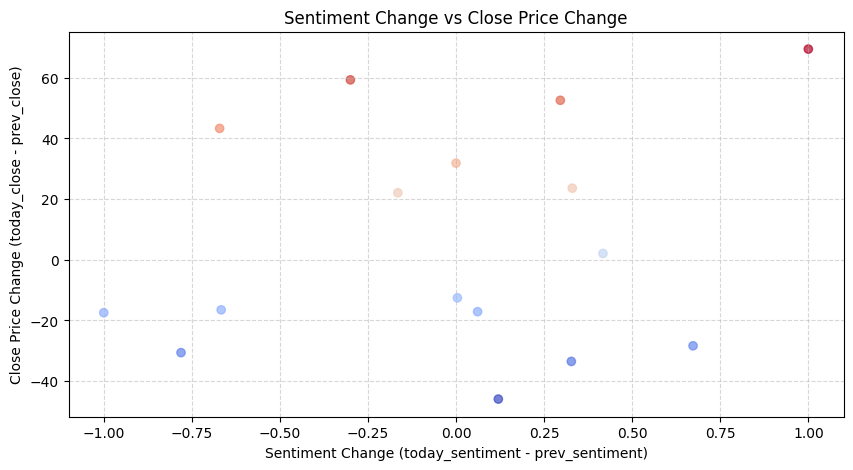

In [94]:
plot_scatter(merged_df['sentiment_change'], merged_df['close_change'], "Sentiment Change (today_sentiment - prev_sentiment)", 
             "Close Price Change (today_close - prev_close)", "Sentiment Change vs Close Price Change")

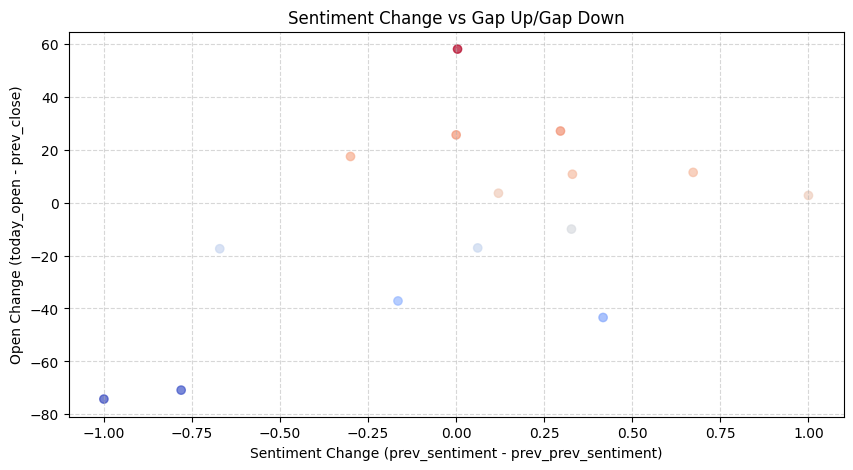

In [95]:
plot_scatter(merged_df['sentiment_change1'], merged_df['open_change'], "Sentiment Change (prev_sentiment - prev_prev_sentiment)", 
                "Open Change (today_open - prev_close)", "Sentiment Change vs Gap Up/Gap Down")

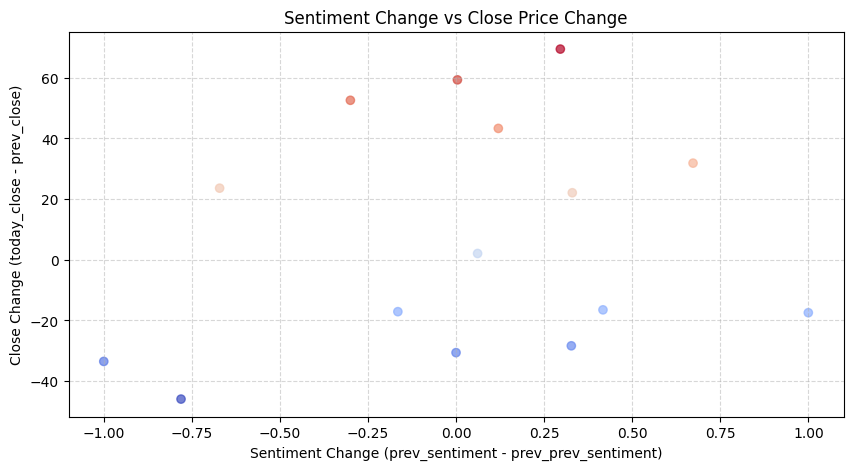

In [96]:
plot_scatter(merged_df['sentiment_change1'], merged_df['close_change'], "Sentiment Change (prev_sentiment - prev_prev_sentiment)", 
             "Close Change (today_close - prev_close)", "Sentiment Change vs Close Price Change")

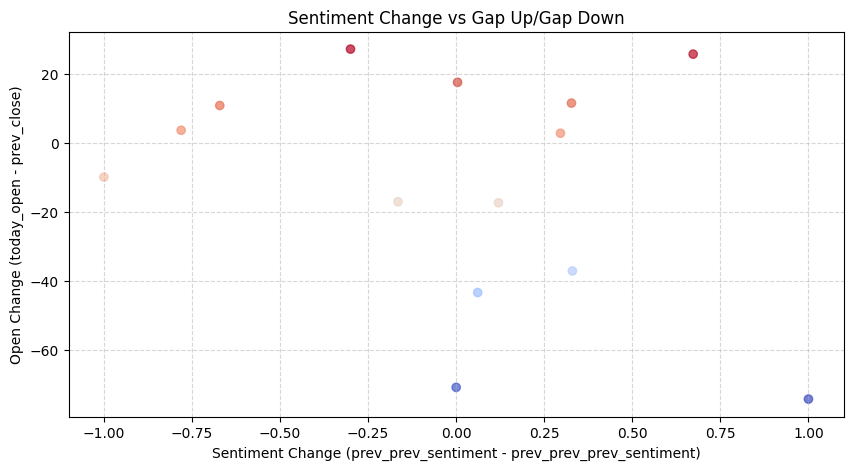

In [97]:
plot_scatter(merged_df['sentiment_change2'], merged_df['open_change'], "Sentiment Change (prev_prev_sentiment - prev_prev_prev_sentiment)", 
                "Open Change (today_open - prev_close)", "Sentiment Change vs Gap Up/Gap Down")

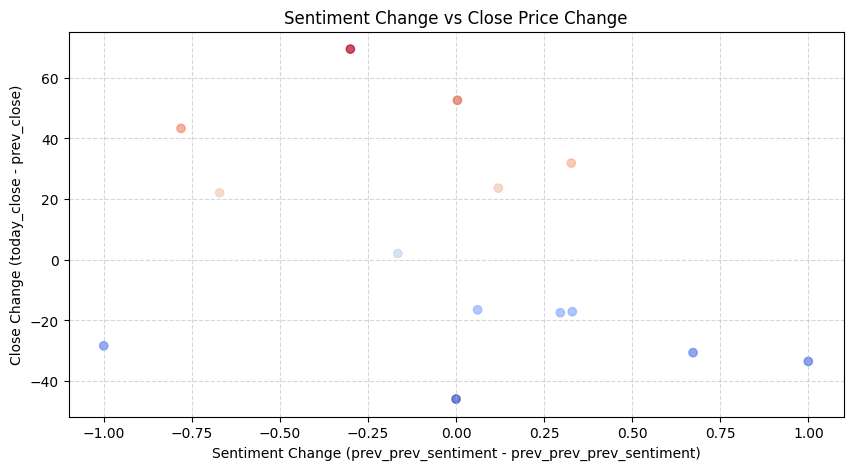

In [98]:
plot_scatter(merged_df['sentiment_change2'], merged_df['close_change'], "Sentiment Change (prev_prev_sentiment - prev_prev_prev_sentiment)", 
             "Close Change (today_close - prev_close)", "Sentiment Change vs Close Price Change")

### Observation:

Above charts are scatter plot between "sentiment score change" vs "gap up/gap down" and "sentiment score change" vs "daily closing price change". First 2 charts are with zero lag to test if there is an immediete impact of sentiment on price. 3rd and 4th chart show the correlation with 1 day lag. 5th and 6th chart show the sentiment change vs price change relation but with 2 days lag. 

Considering all charts it does appear that sentimnet change has an impact on index price with 2 day lag which is visible in gap up or gap down opening or closing price change of the index. Its clear that postive change in sentiment score leads to drop in index closing value and gap down opening after 2 day lag on an average and similarly a negative change in sentiment score leads to rise in index closing value and gap up opening after 2 day lag on an average.

Again we need lots of data to establish this relationship with certainity. Unfortunately here our analysis is limited due to availibility of just 30days of data.

### Plots for VIX

In [99]:
vix_data['Date'] = vix_data['Date'].dt.date

In [100]:
vix_data.sample(3)

Date  Adj Close      Close       High        Low       Open  Volume
13  2025-02-04  17.209999  17.209999  19.110001  16.780001  18.780001       0
14  2025-02-05  15.770000  15.770000  17.750000  15.770000  17.540001       0
10  2025-01-30  15.840000  15.840000  16.420000  15.320000  15.930000       0

In [101]:
merged_vix_df = pd.merge(vix_data, weighted_news_df, on='Date', how='inner')
merged_vix_df.sample(3)

Date  Adj Close      Close       High        Low       Open  Volume  \
0   2025-01-15  16.120001  16.120001  19.139999  15.960000  19.080000       0   
11  2025-02-04  17.209999  17.209999  19.110001  16.780001  18.780001       0   
7   2025-01-29  16.559999  16.559999  18.080000  16.170000  16.420000       0   

    weighted_sentiment  
0             0.000010  
11           -0.331767  
7             1.000000

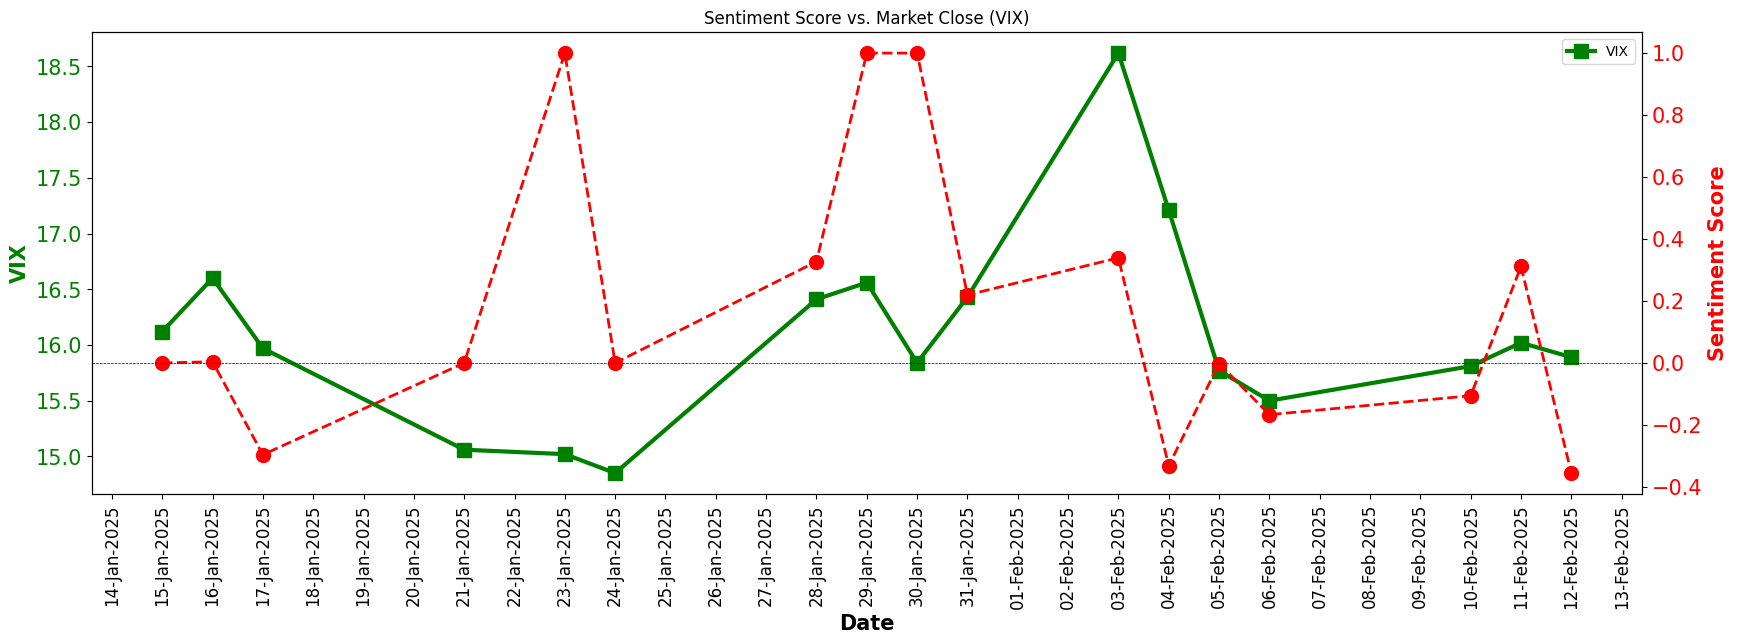

In [102]:
fig, ax1 = plt.subplots(figsize=(20, 6))

ax1.plot(merged_vix_df['Date'], merged_vix_df['Close'], color='green', label='VIX', linewidth=3, marker='s', markersize=10)

ax1.set_xlabel('Date', fontsize=15, fontweight='bold')
ax1.set_ylabel('VIX', color='green', fontsize=15, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='green', labelsize=15)

ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(merged_vix_df['Date'], merged_vix_df['weighted_sentiment'], color='red', linestyle='dashed', linewidth=2, marker='o', markersize=10)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.set_ylabel('Sentiment Score', color='red', fontsize=15, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
ax1.tick_params(axis='x', rotation=90, labelsize=12)

plt.title('Sentiment Score vs. Market Close (VIX)')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.show()

### Observation

In this analysis we try to find if our sentiment score truly captures fear sentiment in the market or not. For this purpose we compare it to VIX which is volality index which is common indicator of fear in the market. 

There seems to be again a lagged relationship between the 2 indicators. 17th-29th Jan sees increase in sentiment score which means increasing fear and this is reflected in the VIX index which also increases from 24th to 3rd feb where it peaks and starts falling over next 2 week again coinciding with a lag with the drop in the sentiment score from Jan 30 onwards. 

# Step4:
  ### In next section we will try to explore a decoder model and check how it performs in sentiment Analysis.

### Model 2: Decoder-Based Model - Tiny LLaMA v1 (1.1 Billion Parameters)

This model is not ideal for sentiment analysis as it is better suited for general text generation. Sentiment analysis requires a deeper understanding of the entire context, which encoder-based models handle more effectively while using less computational power.

* Why LLaMA? If we already have a pre-existing decoder model, we can use it to serve the purpose without needing to build a new model. This is where LLaMA can be helpful.

* Why Tiny LLaMA? The local machine has limited computational power, and other free versions experience timeout errors. Therefore, Tiny LLaMA was used.

In [103]:
with open(os.devnull, "w") as devnull:
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    sys.stdout = devnull
    sys.stderr = devnull
    
    try:
        llm = Llama.from_pretrained(
            repo_id="TheBloke/TinyLlama-1.1B-Chat-v1.0-GGUF",
            filename="tinyllama-1.1b-chat-v1.0.Q2_K.gguf",
        )
    finally:
        sys.stdout = old_stdout
        sys.stderr = old_stderr

### LLaMA Performance Using Prompt Engineering:

In [104]:
messages = [
    {"role": "system", "content": "You analyze financial news and classify its recession fear sentiment."},
    {"role": "user", "content": """Here is a financial news article: 

    "Gold surged last year, outpacing the S&P 500 even in a bull market. Gold prices rose to yet another record high on Monday, extending a yearslong rally as Trump's tariffs upend global trade policy."

    Classify the sentiment of this news as:
    - **Positive** (recession fear is present)
    - **Negative** (news is recession safe)
    - **Neutral** (no indication of recession)

    **Output only one word: Positive, Negative, or Neutral. No explanation.**
    """}
]
output = llm.create_chat_completion(messages = messages)
output

llama_perf_context_print:        load time =    1184.31 ms
llama_perf_context_print: prompt eval time =    1183.96 ms /   192 tokens (    6.17 ms per token,   162.17 tokens per second)
llama_perf_context_print:        eval time =     153.75 ms /    10 runs   (   15.37 ms per token,    65.04 tokens per second)
llama_perf_context_print:       total time =    1339.08 ms /   202 tokens


{'id': 'chatcmpl-a534492b-b04c-42b2-9526-eb2bb45c21d7',
 'object': 'chat.completion',
 'created': 1739900344,
 'model': '/Users/tanusreedas/.cache/huggingface/hub/models--TheBloke--TinyLlama-1.1B-Chat-v1.0-GGUF/snapshots/52e7645ba7c309695bec7ac98f4f005b139cf465/./tinyllama-1.1b-chat-v1.0.Q2_K.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': 'The sentiment of this financial news article is positive.'},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 192, 'completion_tokens': 10, 'total_tokens': 202}}

In [105]:
output["choices"][0]["message"]["content"]

'The sentiment of this financial news article is positive.'

👇 To understand why it generated the sentiment as positive lets change the prompt:

In [106]:
messages = [
    {"role": "system", "content": "You analyze financial news and classify its recession fear sentiment."},
    {"role": "user", "content": """Here is a financial news article: 

    "Gold surged last year, outpacing the S&P 500 even in a bull market. Gold prices rose to yet another record high on Monday, extending a yearslong rally as Trump's tariffs upend global trade policy."

    Classify the sentiment of this news as:
    - **Positive** (recession fear is present)
    - **Negative** (news is recession safe)
    - **Neutral** (no indication of recession)
    """}
]
output = llm.create_chat_completion(messages = messages)
output

Llama.generate: 157 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =    1184.31 ms
llama_perf_context_print: prompt eval time =     121.65 ms /    11 tokens (   11.06 ms per token,    90.43 tokens per second)
llama_perf_context_print:        eval time =    1217.33 ms /    79 runs   (   15.41 ms per token,    64.90 tokens per second)
llama_perf_context_print:       total time =    1348.60 ms /    90 tokens


{'id': 'chatcmpl-aa4db559-11af-4b8c-aa75-d13b28b6f54e',
 'object': 'chat.completion',
 'created': 1739900345,
 'model': '/Users/tanusreedas/.cache/huggingface/hub/models--TheBloke--TinyLlama-1.1B-Chat-v1.0-GGUF/snapshots/52e7645ba7c309695bec7ac98f4f005b139cf465/./tinyllama-1.1b-chat-v1.0.Q2_K.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': 'The sentiment of this news article is positive. The article analyzes financial news and classifies it as recession safe. The article discusses the positive outlook of gold prices, which have risen to a new record high on Monday. The article also notes that the news is recession safe, indicating that the sentiment is positive and there is no indication of recession.'},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 168, 'completion_tokens': 79, 'total_tokens': 247}}

In [107]:
output["choices"][0]["message"]["content"]

'The sentiment of this news article is positive. The article analyzes financial news and classifies it as recession safe. The article discusses the positive outlook of gold prices, which have risen to a new record high on Monday. The article also notes that the news is recession safe, indicating that the sentiment is positive and there is no indication of recession.'

### Observation:

Even after explicitly instructing the model to treat “recession fear” as positive, it does not follow the directive. To improve performance, we can provide more examples (few-shot learning) or simply swap the sentiment generated by the model.

Tiny models lack deep contextual understanding, so prompt design must account for this limitation. However, for larger models like LLaMA, this should not be an issue. With proper prompt engineering, we can directly generate sentiment as needed.

# Step5:
  ### Fine-Tuning a Model:

- We can choose between full fine-tuning or low-rank adaptation (LoRA) fine-tuning. Due to system and time constraints, we will use LoRA.
- Tiny LLaMA has 1.1B parameters, which is significantly larger than FinBERT (~110M parameters). Given our constraints, fine-tuning FinBERT is a more feasible option.

# Fine Tune the Model:

### Before fine-tuning the model, let’s evaluate the base model to check if it meets our requirements. If it does, additional tuning won’t be necessary.

In [108]:
dash_line= "--"*50

In [109]:
#testing with some random texts just to test how the model works
new_sentences = ["fear of recession is present", #should be positive
                 "we are recession safe",  #should be negative
                "Huge drop in GDP",
                "Upside surprise in unemployment data",
                "Strong earning season",
                "Upside surprise in job opening",
                "layoff",
                "market will destroy",
                "Market is going up"]
for sentence in new_sentences:
    result = predict_sentiment(sentence)[0]
    print(sentence,": Sentiment is ",result)
    print(dash_line,end='\n')

fear of recession is present : Sentiment is  Positive
----------------------------------------------------------------------------------------------------
we are recession safe : Sentiment is  Negative
----------------------------------------------------------------------------------------------------
Huge drop in GDP : Sentiment is  Positive
----------------------------------------------------------------------------------------------------
Upside surprise in unemployment data : Sentiment is  Negative
----------------------------------------------------------------------------------------------------
Strong earning season : Sentiment is  Negative
----------------------------------------------------------------------------------------------------
Upside surprise in job opening : Sentiment is  Negative
----------------------------------------------------------------------------------------------------
layoff : Sentiment is  Neutral
-------------------------------------------------------

## Prompt Engineering:
- Prompt engineering is an act of a human changing the prompt (input) to improve the response for a given task.
- Here we will use use few shot inferences as part of prompt engineering.
- They are used when model is supposed to perform a new task which it has never explicitly seen before and now it is expected to perform better based only on the instrunctions in the prompt.</li>

<b>Note:</b> This dataset is manually created to evaluate how prompt engineering influences the model’s sentiment predictions.

In [110]:
dataset = load_dataset('csv', data_files='../data/recession_sentiments_few_shot.csv', delimiter='\t', on_bad_lines='skip')

Generating train split: 0 examples [00:00, ? examples/s]

### Inference Learning:
Comparison of model performance using inference learning versus the base model prediction versus human prediction.

In [111]:
for i, index in enumerate(range(10)):
    statement = dataset['train']['Statement'][index]
    sentiment = dataset['train']['Sentiment'][index]

    prompt = f"""
    You are an expert in economic sentiment analysis. Follow these rules carefully:
    
    - If the statement suggests **economic decline, recession fears, job cuts, inflation or financial instability**, classify it as **Negative**.
    - If the statement suggests **economic growth, new hiring, business expansion, or stability**, classify it as **Positive**.
    - If the statement is **neutral, uncertain or talks about mixed conditions** without strong positive or negative signs, classify it as **Neutral**.

    Now, determine the sentiment of the following statement:

    "{statement}"

    Respond with only one word: **Positive, Negative, or Neutral**.
    """
    model_output =  predict_sentiment(statement)[0]
    inference_output = predict_sentiment(prompt)[0]
    
    print(dash_line)
    print('Example', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'SENTIMENT OF AN ECONOMIST:\n{sentiment}')
    print(dash_line)   
    print(f'BASELINE MODEL SENTIMENT:\n{model_output}')
    print(dash_line)  
    print(f'MODEL SENTIMENT AFTER INFERENCE LEARNING:\n{inference_output}\n')

----------------------------------------------------------------------------------------------------
Example 1
----------------------------------------------------------------------------------------------------
INPUT PROMPT:

    You are an expert in economic sentiment analysis. Follow these rules carefully:
    
    - If the statement suggests **economic decline, recession fears, job cuts, inflation or financial instability**, classify it as **Negative**.
    - If the statement suggests **economic growth, new hiring, business expansion, or stability**, classify it as **Positive**.
    - If the statement is **neutral, uncertain or talks about mixed conditions** without strong positive or negative signs, classify it as **Neutral**.

    Now, determine the sentiment of the following statement:

    "Discusses the impact of job cuts in the tech sector and government plans to reduce federal jobs, indicating concerns about a white-collar recession."

    Respond with only one word: **Posit

### Observation:
- For the given texts, most predictions were already accurate.
- After prompt engineering, the model’s output has changed. The same sentence now generates different outputs when compared to the base model without prompt engineering. While there are a few cases where the output with prompt engineering is not entirely correct, experimenting with different prompts could yield better results. As observed, the prompt significantly alters the sentiment of the same news, so we need to find the most effective prompt for our specific case.

## PEFT- LoRA FineTuning:
Full fine-tuning takes long time, to save time, we will freeze all parameters except the final classification layer and fine-tune only that.
- Pros: Significant time savings compared to full fine-tuning.
- Cons: The model may not achieve the same level of fine-tuning as with full fine-tuning.

👇Let’s evaluate how this approach performs.

In [112]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")

Trainable Parameters: 109754115


We found a dataset on Hugging Face that contains a sufficient number of training and testing samples, making it suitable for various tuning processes.

- Pros: The dataset has adequate samples for robust fine-tuning.
- Cons:
    - This dataset comprises of general financial news and not entirely related to recession theme.
    - It only includes positive and negative sentiments, which may skew predictions when dealing with neutral sentiments.
      
If you have access to a more comprehensive dataset that includes all sentiment types (positive, negative, and neutral) and is specifically related to recession, it is highly recommended for fine-tuning (full, LoRA, QLoRA etc.). This would ensure more accurate and balanced predictions. Since we are conducting this experiment to understand how the process works and its impact on performance, we will proceed. However, without proper data, this process is not advisable.

In [113]:
hf_dataset = load_dataset("MoritzLaurer/sentiment_economy_news")

In [114]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 382
    })
    train_sample: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 1000
    })
    train_sample_numeric: Dataset({
        features: ['text', 'labels', 'articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'],
        num_rows: 1000
    })
})

### Observation:
We have 3000 samples for training and 382 for validation, which is more than sufficient. However, the dataset contains extra features that are not needed for fine-tuning, so we will remove those unnecessary features.

In [115]:
hf_dataset=hf_dataset.remove_columns(['articleid', 'relevance', 'positivity', 'split', 'positivity_rounded', 'idx'])

In [116]:
def preprocess_function(examples, feature_name):
    tokenizer.truncation_side='right'
    return tokenizer(examples[feature_name], truncation=True, padding=True, max_length=512)

def map_labels(statement):
    statement["labels"] = label_map[statement["labels"]]
    return statement

label_map = {'positive': 1, 'neutral': 2, 'negative': 0} # finetuning requires numeric data

tokenized_dataset = hf_dataset.map(lambda examples: preprocess_function(examples, feature_name="text"), batched=True).map(map_labels)

tokenized_train = tokenized_dataset["train"]
tokenized_test = tokenized_dataset["test"]

In [117]:
tokenized_train

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})

In [118]:
tokenized_test

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 382
})

In [119]:
print("First 2 Texts:")
print(dash_line)
print(tokenized_train ['text'][:2])
print(dash_line)
print(dash_line)
print("First 2 Labels:")
print(dash_line)
print(tokenized_train ['labels'][:2])
print(dash_line)
print(dash_line)
print("First 2 Input ids:")
print(dash_line)
print(tokenized_train ['input_ids'][:2])
print(dash_line)
print(dash_line)
print("First 2 Token Type Ids:")
print(dash_line)
print(tokenized_train ['token_type_ids'][:2])
print(dash_line)
print(dash_line)
print("First 2 Attention Mask:")
print(dash_line)
print(tokenized_train ['attention_mask'][:2])
print(dash_line)
print(dash_line)

First 2 Texts:
----------------------------------------------------------------------------------------------------
['Fed Finds Slow Pace Of Growth: Floods and Drought Fail to Halt Recovery Economic Activity Still Expanding Slowly. WASHINGTON, Aug. 4 — Neither flood nor rain nor searing drought is choking off the nation\'s modest economic recovery, even though they have been devastating to the Midwest and the South.</br></br>The 12 Federal Reserve Banks reported today that economic activity in most districts, including the Midwest, continued to expand "slowly to moderately” in June and the first half of July.</br></br>"The effects of flooding were said to be highly concentrated and were not seen to threaten overall economic expansion,” the Federal Reserve said in its latest survey of regional economic conditions, a report known as the beige book.</br></br>The Federal Reserve’s latest appraisal of economic conditions was based on surveys of farmers, bankers and business executives condu

In [120]:
# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True
        
# Define LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.01,
    task_type=TaskType.SEQ_CLS # "SEQ_CLS"
)
# Apply LoRA to the existing model
finbert_model = get_peft_model(model, lora_config)

# Print the number of trainable parameters to check
total_trainable_params = sum(p.numel() for p in finbert_model.parameters() if p.requires_grad)
print(f"Total trainable parameters after freezing some layers: {total_trainable_params}")

Total trainable parameters after freezing some layers: 297219


💡 Compared to full fine tuning where we trained 110M parameters here we will only train approx 0.3M parameters.

In [121]:
results_path = os.path.join(fine_tuned_model_path, results_dir)
logs_path = os.path.join(fine_tuned_model_path, logs_dir)
model_path = os.path.join(fine_tuned_model_path, model_ver)

In [122]:
accuracy = evaluate.load("accuracy")

# Function for Evaluation Metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir=results_path,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=logs_path,
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    use_cpu=True)

trainer = Trainer(
    model=finbert_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [123]:
try:
    print("We are searching for a pretrained model in",model_path)
    lora_model = BertForSequenceClassification.from_pretrained(model_path, ignore_mismatched_sizes=True)
    lora_nlp = pipeline("sentiment-analysis", model=lora_model, tokenizer=tokenizer, device="cpu")
    print("The model is already trained and loaded successfully. The model name is: lora_model")
except Exception as e:
    print("The model is not trained and will be trained now.")
    trainer.train()
    trainer.save_model(model_path)
    results = trainer.evaluate()
    print("Evaluation Results:", results)
    lora_model = BertForSequenceClassification.from_pretrained(model_path, ignore_mismatched_sizes=True)
    lora_nlp = pipeline("sentiment-analysis", model=lora_model, tokenizer=tokenizer, device="cpu")
    print("The model is now trained and loaded successfully. The model name is: lora_model")

We are searching for a pretrained model in ./fine_tuned_models/model_v1.0


Device set to use cpu


The model is already trained and loaded successfully. The model name is: lora_model


### Observation:
The LoRA fine-tuning approach achieved an accuracy of 66.49%.

- Pros:
    - Improved Accuracy: It will improve accuracy with proper data.
    - Reduced Training Time: It is expected to achieve nearly the same performance as full fine-tuning but in significantly less time.
    - Good Generalization: Comparable training and validation losses indicate the model generalizes well and is likely to perform effectively on unseen data.
- Cons: The performance is will most likely never reach full finetuning.

Let’s test the LoRA Model on a sample text Data.

In [124]:
def swap_sentiment(current_label):
    if current_label == 'Positive':
        label = 'Negative'
    elif current_label == 'Negative':
        label = 'Positive'
    else:
        label = current_label
    return label

In [125]:
result=lora_nlp("we are not recession safe")[0]
print(f"Sentiment by Fine Tuned Model: {swap_sentiment(result['label'])}")
print(f"Confidence Level: {result['score']}")

Sentiment by Fine Tuned Model: Neutral
Confidence Level: 0.7638919949531555


As the output is correct we will try the model with our previous dataset and observe how it performs:

In [126]:
for i, index in enumerate(range(10)):
    statement = dataset['train']['Statement'][index]
    sentiment = dataset['train']['Sentiment'][index]

    base_model_output = predict_sentiment(statement)[0]
    lora_output = swap_sentiment(lora_nlp(statement)[0]['label'])
    
    print(dash_line)
    print(f'{i + 1}. INPUT PROMPT:\n{statement}')
    print(dash_line)
    print(f'SENTIMENT OF AN ECONOMIST:\n{sentiment}')
    print(dash_line)   
    print(f'BASELINE MODEL SENTIMENT:\n{base_model_output}')
    print(dash_line)  
    print(f'MODEL SENTIMENT AFTER FINE TUNING:\n{lora_output}\n')

----------------------------------------------------------------------------------------------------
1. INPUT PROMPT:
Discusses the impact of job cuts in the tech sector and government plans to reduce federal jobs, indicating concerns about a white-collar recession.
----------------------------------------------------------------------------------------------------
SENTIMENT OF AN ECONOMIST:
Positive
----------------------------------------------------------------------------------------------------
BASELINE MODEL SENTIMENT:
Positive
----------------------------------------------------------------------------------------------------
MODEL SENTIMENT AFTER FINE TUNING:
Neutral

----------------------------------------------------------------------------------------------------
2. INPUT PROMPT:
Discusses conflicting economic indicators, with some showing resilience while others hint at potential slowdowns. Economists remain divided on future outcomes.
-------------------------------------

# Final Thoughts & Recommendations

- **The final model** choice will depend on the specific situation:
    - **Situation 1:** We want to use exisiting model and based on that want to build our sentiment analysis system for news, in that case I will choose FinBERT or some similar encoder model finetuned on Financial news or more specifically recession news.
    - **Situation 2:** If we have enough recession-specific data, computational power, and time to train, I would select a base encoder model like BERT and fully fine-tune it on the recession data for building the system.
    - **Situation 3:** If there are computational power and/or time constraints but we still want a model nearly as good as the previous option, PEFT fine-tuning using LoRA or similar methods would be a suitable choice.
    - **Situation 4:** If the team is already using a powerful decoder model like ChatGPT, LLaMA, or similar, prompt engineering would be the best approach.
    - **Other situation:** Depending on the context, the model and approach for the final model should be selected accordingly.
- **Challenges:**
    - **Free API:** Free APIs like News API and Yahoo News do not provide large amounts of data. If more data is accessible, finding patterns, such as how the market will change with sentiment, would be much easier and more accurate.
    - **Computational Power:** Local machines or free plans like Colab or Kaggle are not suitable for building, testing, and/or tuning a transformer model. If you plan to run this notebook on your machine and have sufficient GPU access, I recommend changing all the relevant code to switch the settings from CPU to GPU. Also, consider upgrading from Tiny LLaMA to LLaMA version 2 or 3 for better results.
    - **Access to Dataset:** Access to the correct dataset for tuning is essential. Before running this file, if you find a better dataset aligned with our goals, replace it in the file. A fine-tuned model with the right dataset will perform much better.
- **Future Change:**
    - I plan to experiment with different prompts to improve model performance.
    - If I gain access to a better machine or suitable datasets (e.g., news, S&P500, sentiment), I will run this notebook with those data and settings.
    - I also intend to try other open-source models and explore different fine-tuning methods and metrics to further improve the model.